# Multilevel Elasticities for a Single Product

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns

from numpy.typing import NDArray
from pydantic import BaseModel, Field, model_validator, field_validator
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "multilevel_elasticities_single_sku"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

---

## Part 1: Data Generating Process

### Entities Definition

In [3]:
class Sku(BaseModel):
    id: int = Field(..., ge=0)
    prices: NDArray[np.float_]
    quantities: NDArray[np.float_]

    class Config:
        arbitrary_types_allowed = True

    @field_validator("prices", "quantities")
    def validate_gt_0(cls, value):
        if (value <= 0).any():
            raise ValueError("prices and quantities must be positive")
        return value

    @field_validator("prices", "quantities")
    def validate_size_gt_0(cls, value):
        if value.size == 0:
            raise ValueError("prices and quantities must have at least one element")
        return value

    @model_validator(mode="before")
    def validate_sizes(cls, values):
        if values["prices"].size != values["quantities"].size:
            raise ValueError("prices and quantities must have the same size")
        return values

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            data={
                "item_id": self.id,
                "price": self.prices,
                "quantities": self.quantities,
                "time_step": np.arange(self.prices.size)[::-1],
            }
        )


class Store(BaseModel):
    id: int = Field(..., ge=0)
    items: list[Sku] = Field(..., min_items=1)

    @field_validator("items")
    def validate_item_ids(cls, value):
        if len({item.id for item in value}) != len(value):
            raise ValueError("items must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([item.to_dataframe() for item in self.items], axis=0)
        df["store_id"] = self.id
        df["region_store_id"] = f"r-{self.id}_s-" + df["store_id"].astype(str)
        return df.reset_index(drop=True)


class Region(BaseModel):
    id: int = Field(..., ge=0)
    stores: list[Store] = Field(..., min_items=1)
    median_income: float = Field(..., gt=0)  # Z_j

    @field_validator("stores")
    def validate_store_ids(cls, value):
        if len({store.id for store in value}) != len(value):
            raise ValueError("stores must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([store.to_dataframe() for store in self.stores], axis=0)
        df["region_id"] = self.id
        df["median_income"] = self.median_income
        return df.reset_index(drop=True)


class Market(BaseModel):
    regions: list[Region] = Field(..., min_items=1)

    @field_validator("regions")
    def validate_region_ids(cls, value):
        if len({region.id for region in value}) != len(value):
            raise ValueError("regions must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([region.to_dataframe() for region in self.regions], axis=0)
        return df.reset_index(drop=True)

In [4]:
class LinearRegressionConfig(BaseModel):
    intercept: float
    slope: float
    sigma: float = Field(..., gt=0)


class MultiLevelElasticitiesDataGenerator(BaseModel):
    rng: np.random.Generator
    n_regions: int = Field(..., gt=0)
    time_range_mu: float = Field(..., gt=0)
    time_range_sigma: float = Field(..., gt=0)
    n_stores_per_region_mu: float = Field(..., gt=0)
    n_stores_per_region_sigma: float = Field(..., gt=0)
    median_income_per_region_mu: float = Field(..., gt=0)
    median_income_per_region_sigma: float = Field(..., gt=0)
    intercepts_lr_config: LinearRegressionConfig
    slopes_lr_config: LinearRegressionConfig
    price_mu: float = Field(..., gt=0)
    price_sigma: float = Field(..., gt=0)
    epsilon: float = Field(..., gt=0)

    class Config:
        arbitrary_types_allowed = True

    def get_n_stores_per_region_draws(self) -> NDArray:
        n_stores_per_region_dist = pm.NegativeBinomial.dist(
            mu=self.n_stores_per_region_mu, alpha=self.n_stores_per_region_sigma
        )
        n_stores_per_region_draws = pm.draw(
            n_stores_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return n_stores_per_region_draws + 2

    def get_median_income_per_region_draws(self) -> NDArray:
        median_income_per_region_dist = pm.Gamma.dist(
            mu=self.median_income_per_region_mu,
            sigma=self.median_income_per_region_sigma,
        )
        median_income_per_region_draws = pm.draw(
            median_income_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return median_income_per_region_draws + 1

    def get_store_time_range(self) -> int:
        time_range_dist = pm.NegativeBinomial.dist(
            mu=self.time_range_mu, alpha=self.time_range_sigma
        )
        time_range_samples = pm.draw(
            vars=time_range_dist, draws=1, random_seed=self.rng
        ).item()
        return time_range_samples + 2

    def get_alpha_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        alpha_j_dist = pm.Normal.dist(
            mu=self.intercepts_lr_config.intercept
            + self.intercepts_lr_config.slope * median_income_per_region,
            sigma=self.intercepts_lr_config.sigma,
        )
        return pm.draw(alpha_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_beta_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        beta_j_dist = pm.Normal.dist(
            mu=self.slopes_lr_config.intercept
            + self.slopes_lr_config.slope * median_income_per_region,
            sigma=self.slopes_lr_config.sigma,
        )
        return pm.draw(beta_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_prices_samples(self, store_time_range: int) -> NDArray:
        price_dist = pm.Gamma.dist(
            mu=self.price_mu,
            sigma=self.price_sigma,
        )
        return pm.draw(price_dist, draws=store_time_range, random_seed=self.rng)

    def get_quantities_samples(
        self, alpha_j_samples, beta_j_samples, prices_samples
    ) -> NDArray:
        log_quantities_dist = pm.Normal.dist(
            mu=alpha_j_samples + beta_j_samples * np.log(prices_samples),
            sigma=self.epsilon,
        )
        log_quantities_samples = pm.draw(
            log_quantities_dist, draws=1, random_seed=self.rng
        )
        return np.exp(log_quantities_samples)

    def create_store(self, id: int, median_income_per_region: float) -> Store:
        store_time_range = self.get_store_time_range()
        alpha_j_samples = self.get_alpha_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        beta_j_samples = self.get_beta_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        prices_samples = self.get_prices_samples(store_time_range=store_time_range)
        quantities_samples = self.get_quantities_samples(
            alpha_j_samples=alpha_j_samples,
            beta_j_samples=beta_j_samples,
            prices_samples=prices_samples,
        )
        return Store(
            id=id,
            items=[Sku(id=0, prices=prices_samples, quantities=quantities_samples)],
        )

    def create_region(
        self, id: int, n_stores_per_region: int, median_income_per_region: float
    ) -> Region:
        stores: list[Store] = [
            self.create_store(id=i, median_income_per_region=median_income_per_region)
            for i in range(n_stores_per_region)
        ]
        return Region(id=id, stores=stores, median_income=median_income_per_region)

    def run(self) -> Market:
        n_stores_per_region_draws = self.get_n_stores_per_region_draws()
        median_income_per_region_draws = self.get_median_income_per_region_draws()

        regions: list[Region] = [
            self.create_region(
                id=j,
                n_stores_per_region=n_stores_per_region_draws[j],
                median_income_per_region=median_income_per_region_draws[j],
            )
            for j in tqdm(range(self.n_regions))
        ]

        return Market(regions=regions)

In [5]:
data_generator = MultiLevelElasticitiesDataGenerator(
    rng=rng,
    n_regions=8,
    time_range_mu=20,
    time_range_sigma=5,
    n_stores_per_region_mu=16,
    n_stores_per_region_sigma=2,
    median_income_per_region_mu=5,
    median_income_per_region_sigma=2.5,
    intercepts_lr_config=LinearRegressionConfig(intercept=1, slope=0.3, sigma=0.02),
    slopes_lr_config=LinearRegressionConfig(intercept=-0.1, slope=-0.6, sigma=0.02),
    price_mu=1.5,
    price_sigma=0.25,
    epsilon=0.3,
)

In [6]:
market = data_generator.run()

  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
market_df = market.to_dataframe()

market_df.head(10)


item_id     price  quantities  time_step  store_id region_store_id  \
0        0  1.335446    6.079984         16         0         r-0_s-0   
1        0  1.702792    3.723573         15         0         r-0_s-0   
2        0  1.699778    3.298036         14         0         r-0_s-0   
3        0  1.335844    5.619059         13         0         r-0_s-0   
4        0  1.517213    4.240062         12         0         r-0_s-0   
5        0  1.434605    4.541125         11         0         r-0_s-0   
6        0  1.572367    2.675704         10         0         r-0_s-0   
7        0  1.579389    3.066581          9         0         r-0_s-0   
8        0  1.084296   20.105126          8         0         r-0_s-0   
9        0  1.081592   11.850537          7         0         r-0_s-0   

   region_id  median_income  
0          0       5.756003  
1          0       5.756003  
2          0       5.756003  
3          0       5.756003  
4          0       5.756003  
5          0       5.756003  
6          0       5.756003  
7          0       5.756003  
8          0       5.756003  
9          0       5.756003

In [8]:
market_df = market_df.assign(
    log_price=lambda x: np.log(x["price"]),
    log_quantities=lambda x: np.log(x["quantities"]),
    region_id=lambda x: x["region_id"].astype("category"),
    region_store_id=lambda x: x["region_store_id"].astype("category"),
)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Price vs Quantities by Region')

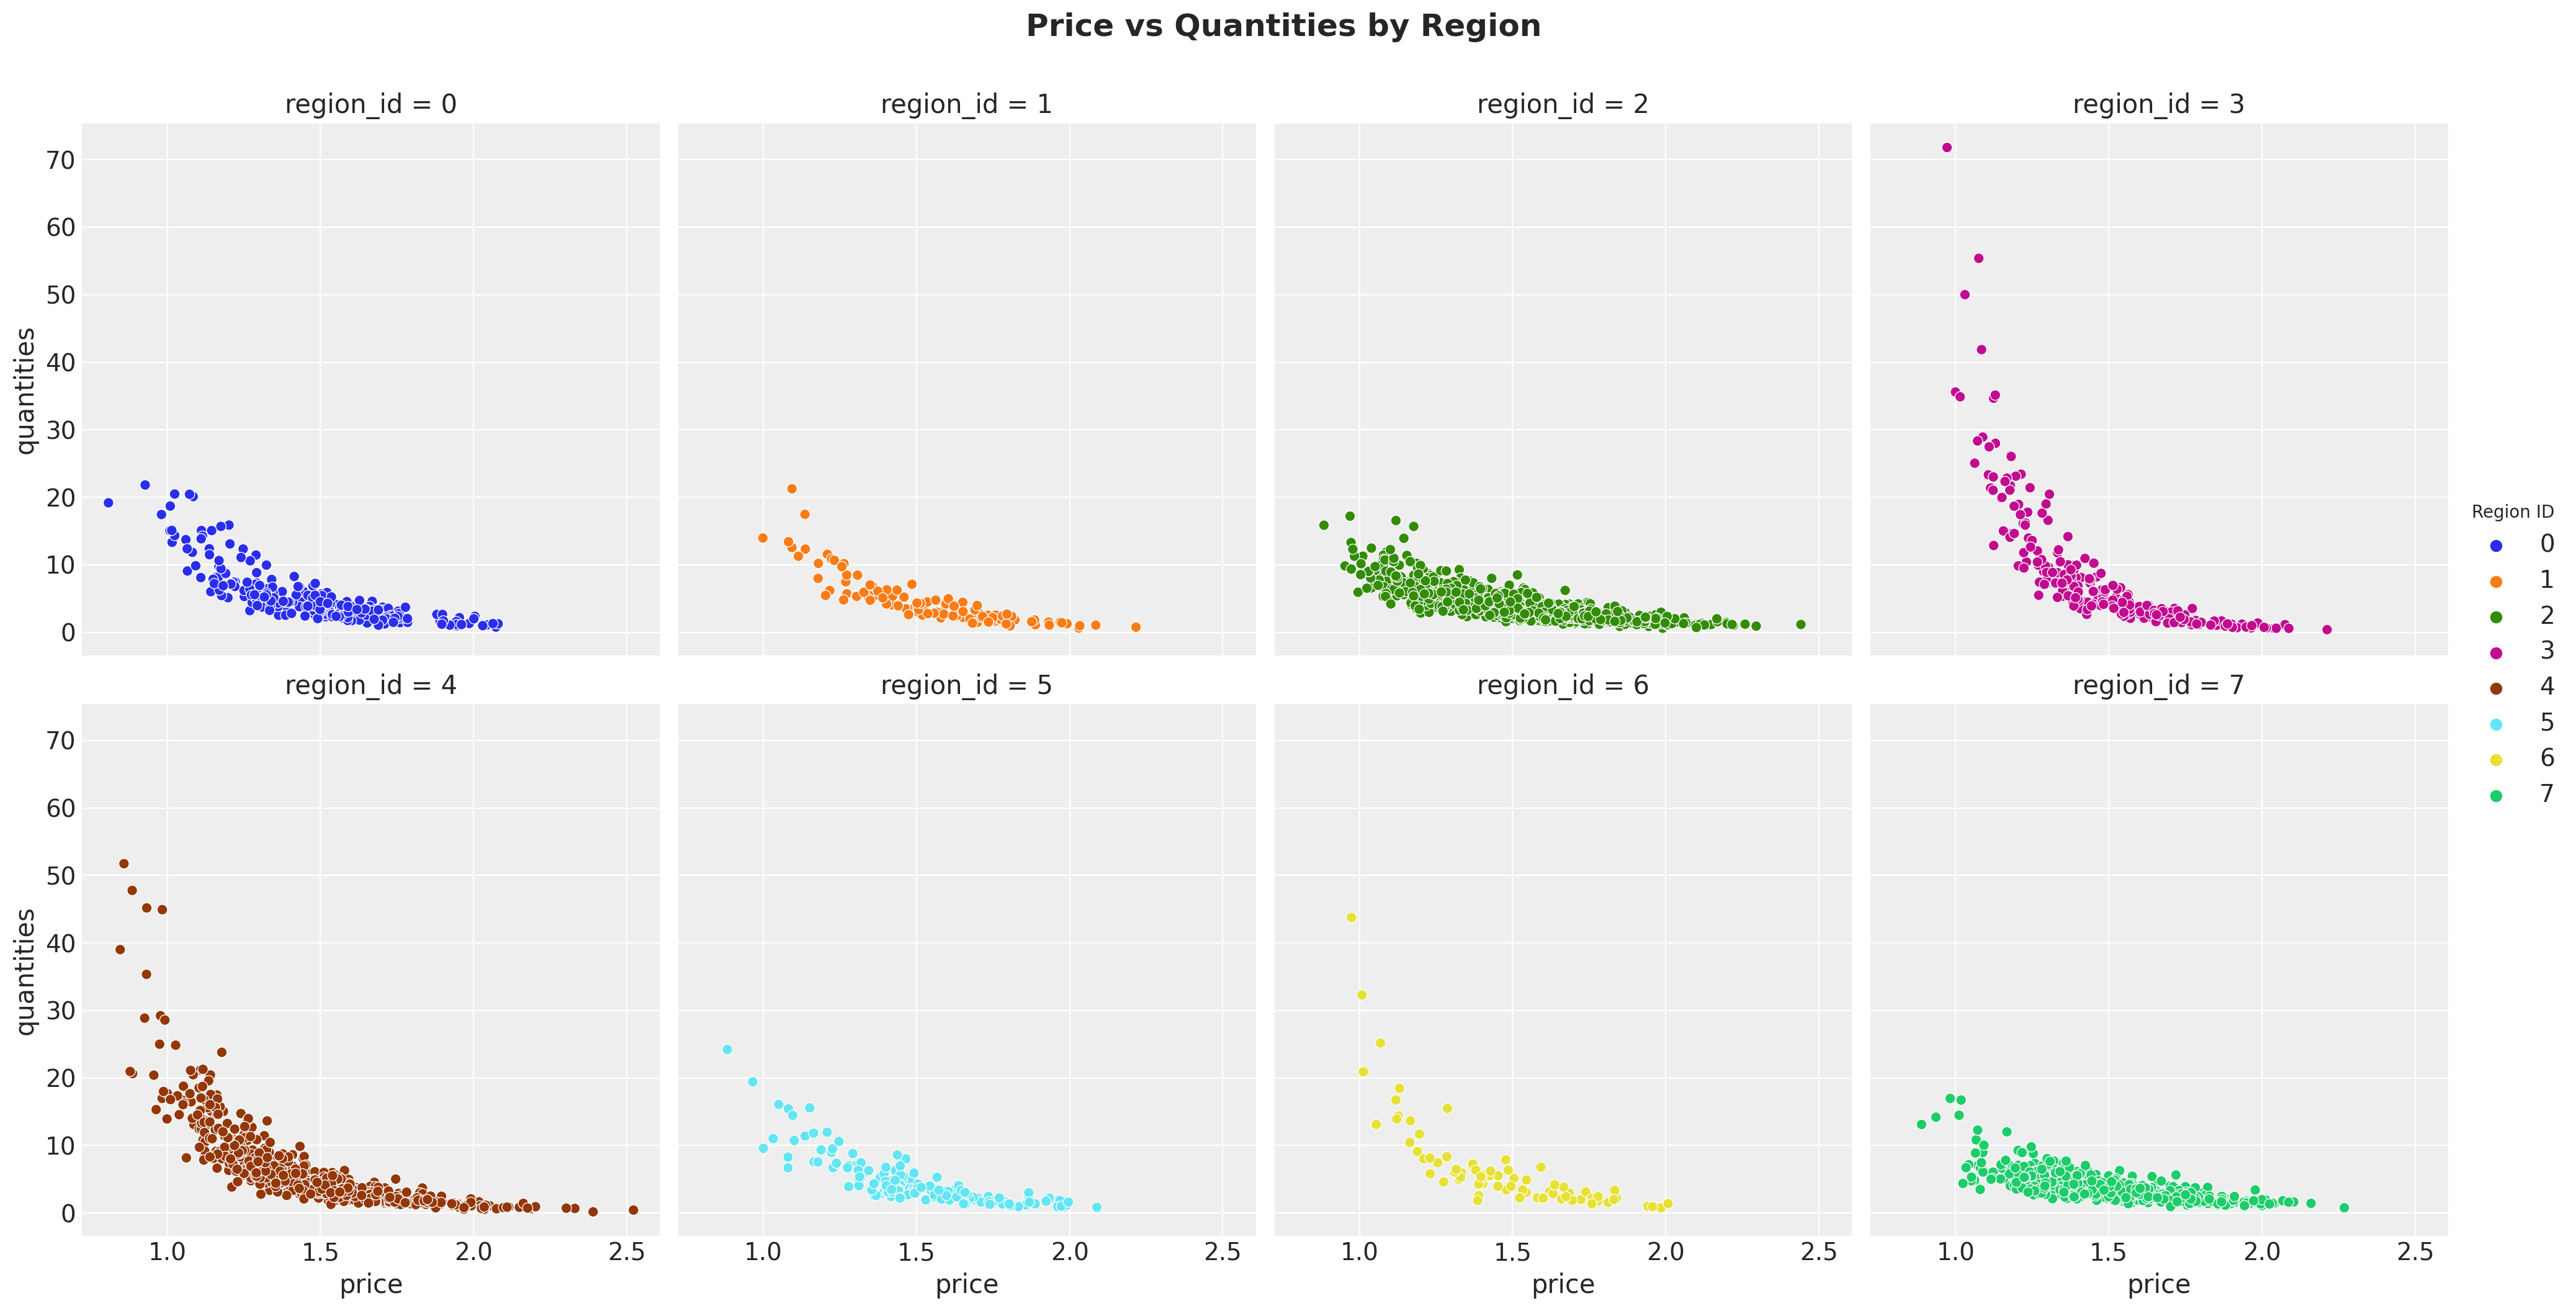

In [9]:
g = sns.relplot(
    data=market_df,
    x="price",
    y="quantities",
    kind="scatter",
    col="region_id",
    col_wrap=4,
    hue="region_id",
    facet_kws={"sharex": True, "sharey": True},
)
legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle("Price vs Quantities by Region", y=1.05, fontsize=18, fontweight="bold")


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Log Price vs Log Quantities by Region')

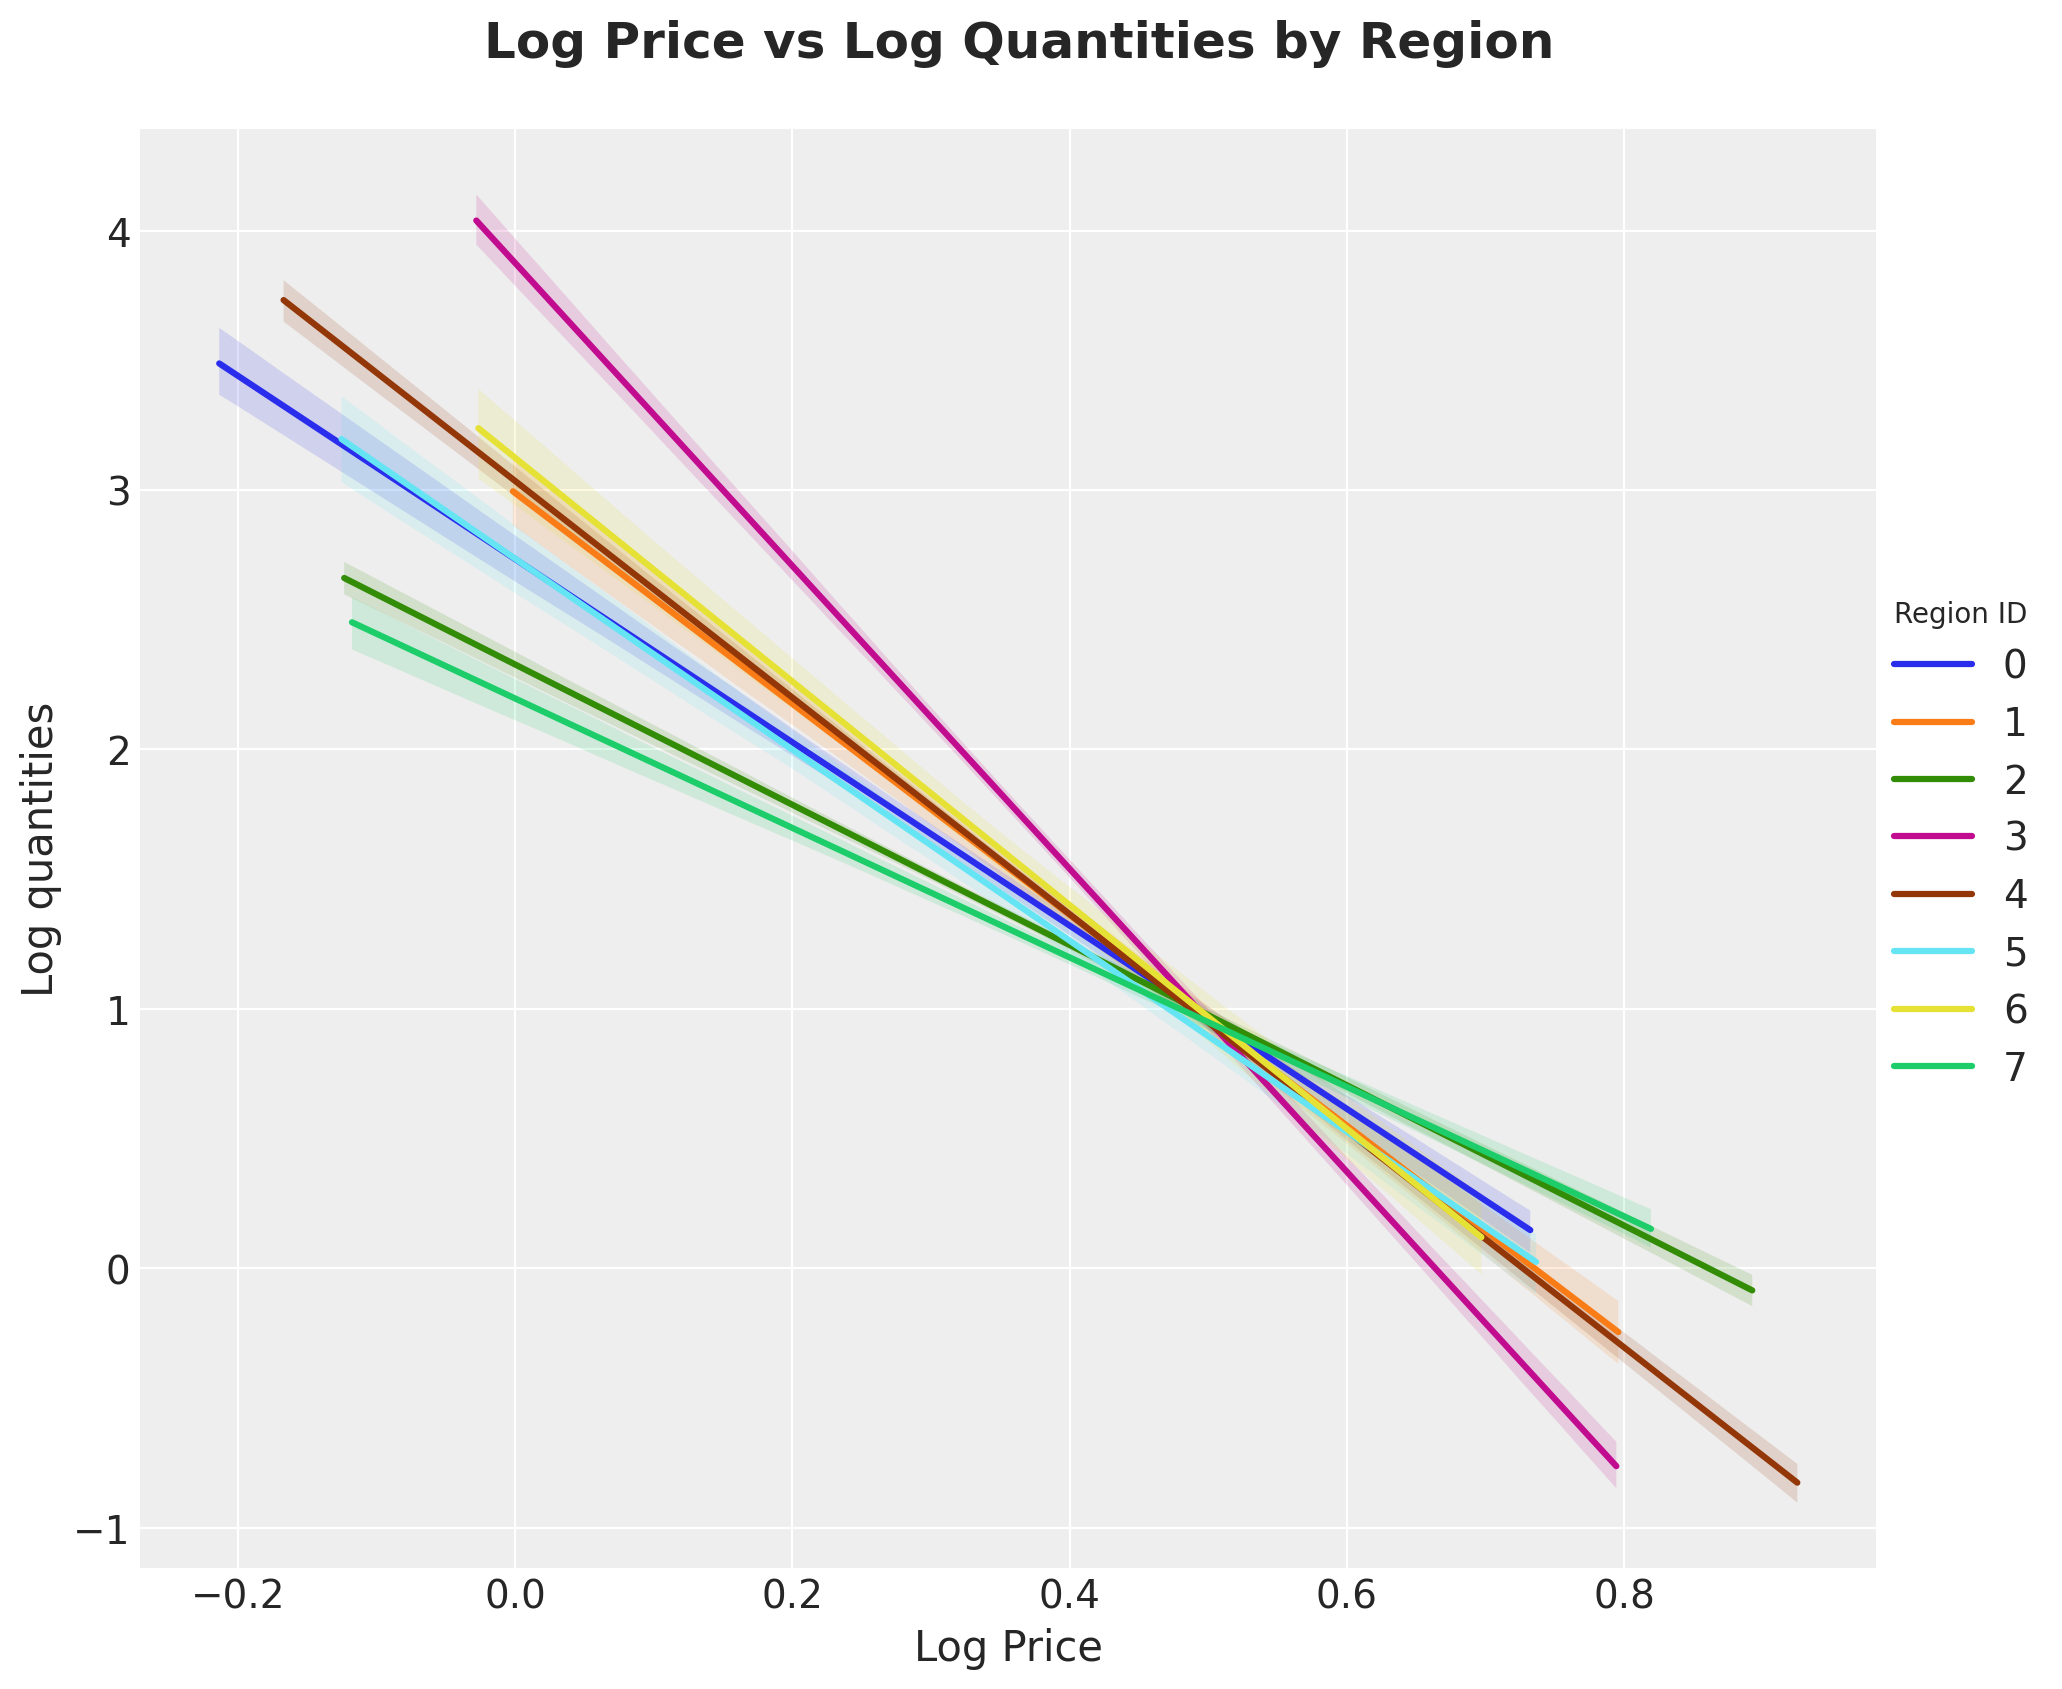

In [10]:
g = sns.lmplot(
    data=market_df,
    x="log_price",
    y="log_quantities",
    hue="region_id",
    height=8,
    aspect=1.2,
    scatter=False,
)
g.set_axis_labels(x_var="Log Price", y_var="Log quantities")
legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle(
    "Log Price vs Log Quantities by Region", y=1.05, fontsize=18, fontweight="bold"
)


Text(0.5, 1.0, 'Median Income by Region')

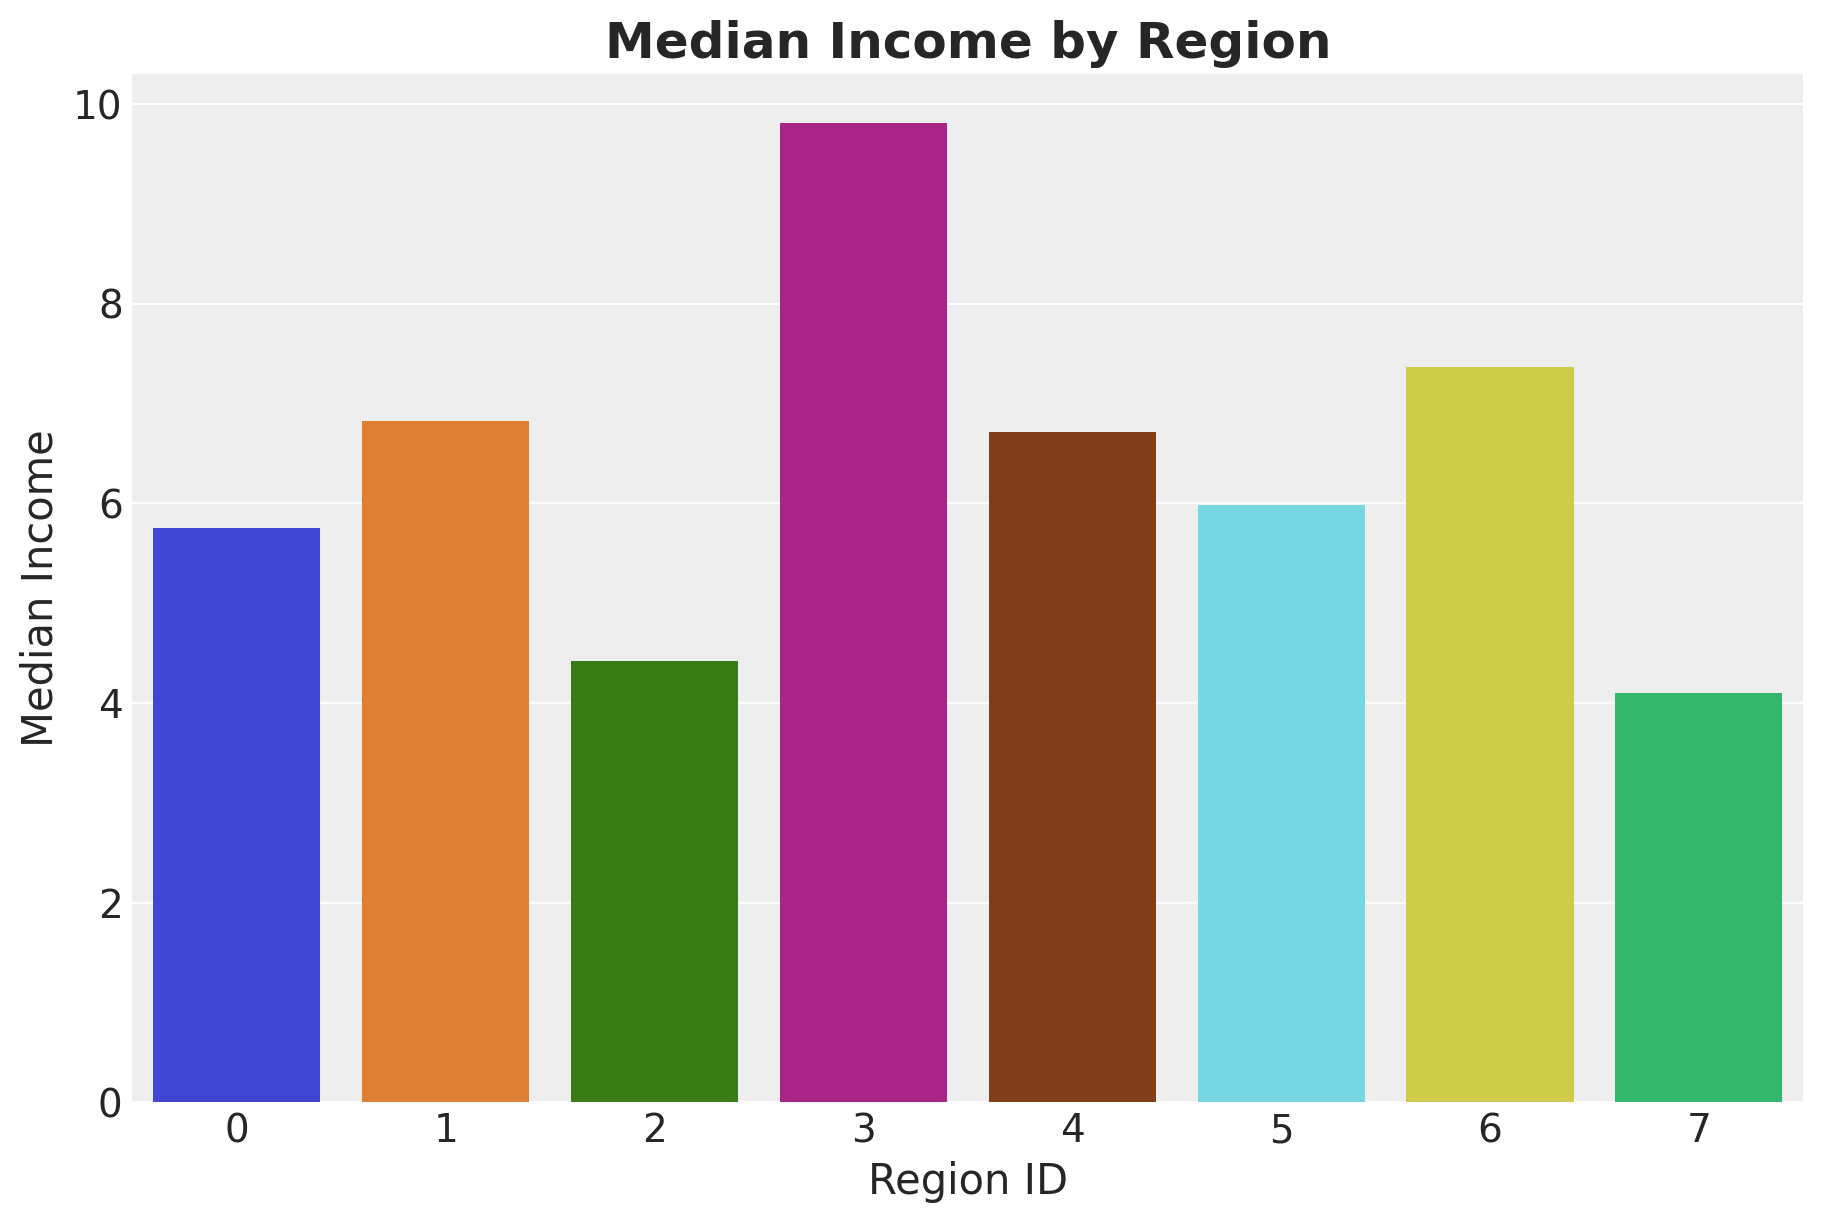

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
(
    market_df.groupby("region_id", as_index=False)
    .agg({"median_income": np.mean})
    .pipe((sns.barplot, "data"), x="region_id", y="median_income", ax=ax)
)
ax.set(xlabel="Region ID", ylabel="Median Income")
ax.set_title(label="Median Income by Region", fontsize=18, fontweight="bold")


Text(0.5, 1.0, 'Price by Store in Region 6')

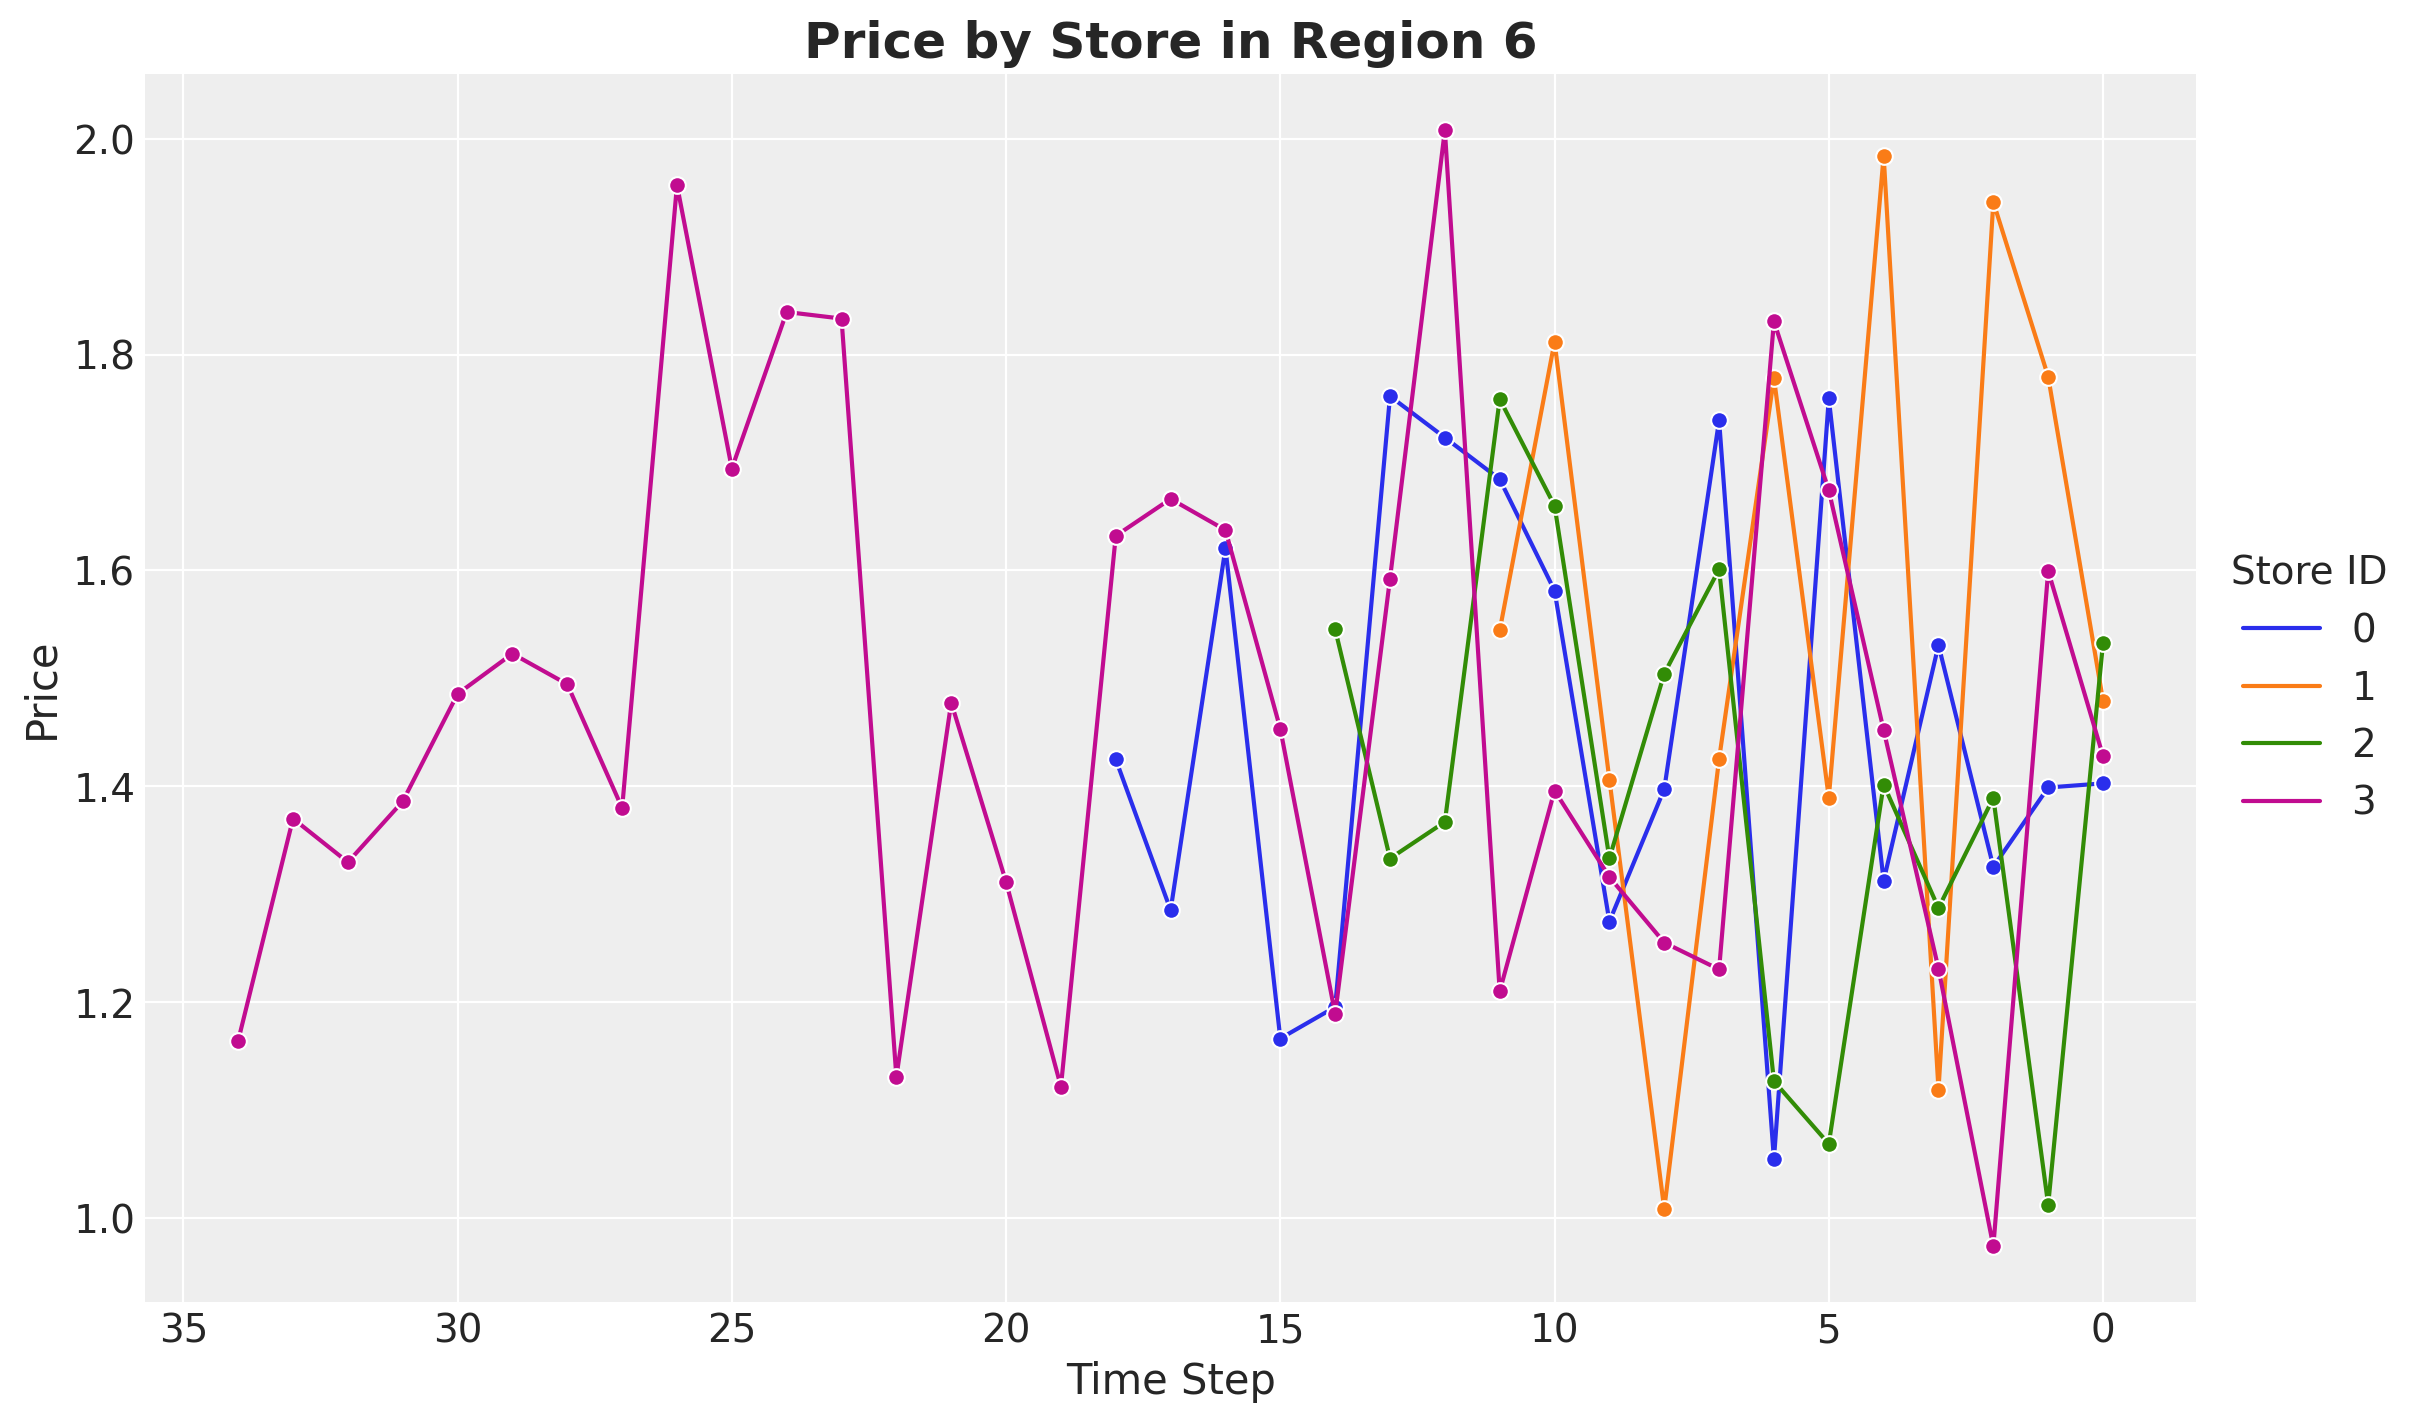

In [12]:
fig, ax = plt.subplots()
sns.lineplot(
    data=market_df.query("region_id == 6").assign(
        store_id=lambda x: x["store_id"].astype("category")
    ),
    x="time_step",
    y="price",
    hue="store_id",
    marker="o",
)
ax.invert_xaxis()
ax.legend(
    title="Store ID", title_fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5)
)
ax.set(xlabel="Time Step", ylabel="Price")
ax.set_title(label="Price by Store in Region 6", fontsize=18, fontweight="bold")


In [13]:
obs = market_df.index.to_numpy()
price = market_df["price"].to_numpy()
log_price = market_df["log_price"].to_numpy()
quantities = market_df["quantities"].to_numpy()
log_quantities = market_df["log_quantities"].to_numpy()
median_income_idx, median_income = market_df["median_income"].factorize(sort=True)
store_idx, store = market_df["region_store_id"].factorize(sort=True)
region_idx, region = market_df["region_id"].factorize(sort=True)

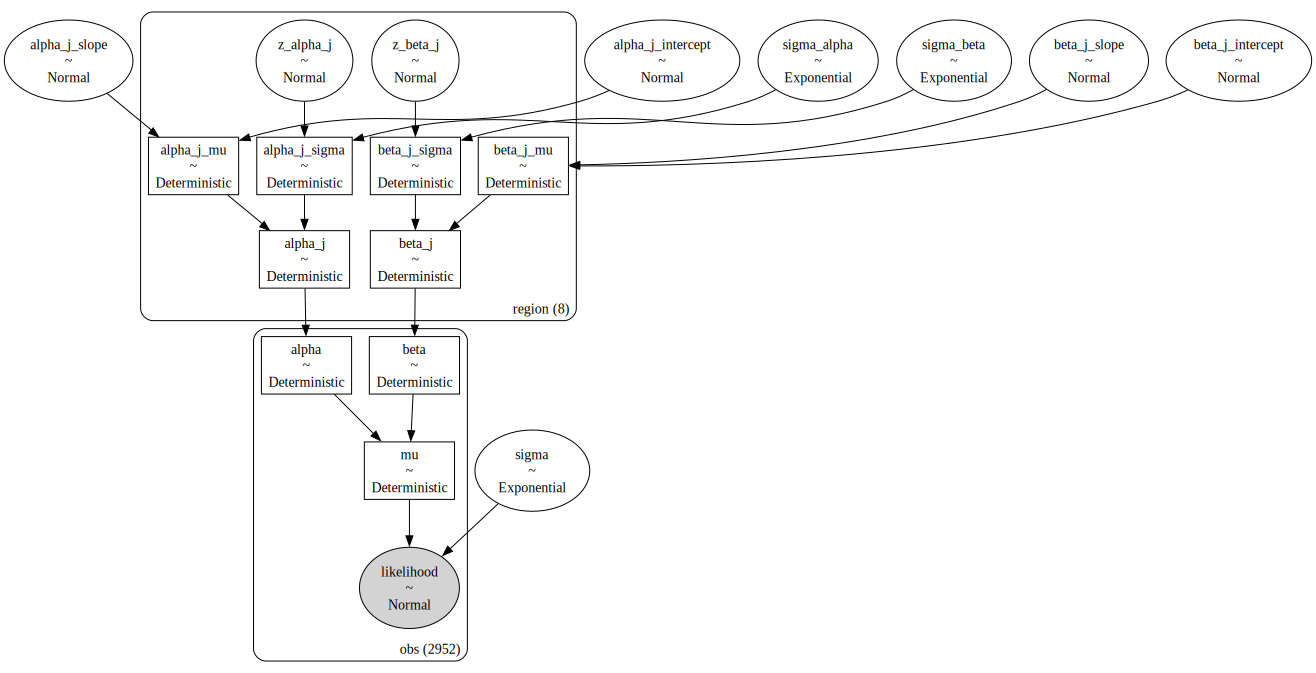

In [14]:
coords = {"store": store, "region": region, "obs": obs}

with pm.Model(coords=coords) as model:
    # --- Priors ---

    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
    alpha_j_slope = pm.Normal(name="alpha_j_slope", mu=0, sigma=1)
    sigma_alpha = pm.Exponential(name="sigma_alpha", lam=1 / 0.1)
    z_alpha_j = pm.Normal(name="z_alpha_j", mu=0, sigma=1, dims="region")

    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)
    beta_j_slope = pm.Normal(name="beta_j_slope", mu=0, sigma=1)
    sigma_beta = pm.Exponential(name="sigma_beta", lam=1 / 0.1)
    z_beta_j = pm.Normal(name="z_beta_j", mu=0, sigma=1, dims="region")

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    # --- Parametrization ---

    alpha_j_mu = pm.Deterministic(
        name="alpha_j_mu",
        var=alpha_j_intercept + alpha_j_slope * median_income.to_numpy(),
        dims="region",
    )
    alpha_j_sigma = pm.Deterministic(
        name="alpha_j_sigma", var=sigma_alpha * z_alpha_j, dims="region"
    )
    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_mu + alpha_j_sigma,
        dims="region",
    )

    beta_j_mu = pm.Deterministic(
        name="beta_j_mu",
        var=beta_j_intercept + beta_j_slope * median_income.to_numpy(),
        dims="region",
    )
    beta_j_sigma = pm.Deterministic(
        name="beta_j_sigma", var=sigma_beta * z_beta_j, dims="region"
    )
    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_mu + beta_j_sigma,
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

    # --- Likelihood ---

    pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=log_quantities, dims="obs"
    )

pm.model_to_graphviz(model=model)

In [15]:
with model:
    idata = pm.sample(
        target_accept=0.95,
        draws=4_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.594497
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:04:37.323295
Transforming variables...
Transformation time =  0:00:01.141551


Sampling: [likelihood]


In [16]:
idata["sample_stats"]["diverging"].sum().item()

0

In [17]:
var_names = [
    "alpha_j_intercept",
    "alpha_j_slope",
    "beta_j_intercept",
    "beta_j_slope",
    "alpha_j",
    "beta_j",
    "sigma",
]

az.summary(data=idata, var_names=var_names)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_j_intercept  2.329  0.650   1.065    3.480      0.008    0.006   
alpha_j_slope      0.074  0.100  -0.107    0.264      0.001    0.001   
beta_j_intercept  -1.997  0.883  -3.664   -0.341      0.010    0.007   
beta_j_slope      -0.259  0.138  -0.523   -0.005      0.002    0.001   
alpha_j[0]         2.731  0.043   2.654    2.814      0.000    0.000   
alpha_j[1]         2.968  0.075   2.825    3.108      0.000    0.000   
alpha_j[2]         2.330  0.025   2.283    2.377      0.000    0.000   
alpha_j[3]         3.849  0.047   3.762    3.938      0.000    0.000   
alpha_j[4]         3.033  0.027   2.984    3.084      0.000    0.000   
alpha_j[5]         2.737  0.061   2.620    2.848      0.000    0.000   
alpha_j[6]         3.110  0.076   2.972    3.259      0.000    0.000   
alpha_j[7]         2.209  0.036   2.140    2.275      0.000    0.000   
beta_j[0]         -3.525  0.103  -3.716   -3.330      0.001    0.000   
beta_j[1]         -4.019  0.167  -4.335   -3.713      0.001    0.001   
beta_j[2]         -2.709  0.058  -2.820   -2.601      0.000    0.000   
beta_j[3]         -5.775  0.112  -5.983   -5.565      0.001    0.001   
beta_j[4]         -4.170  0.063  -4.289   -4.053      0.000    0.000   
beta_j[5]         -3.685  0.143  -3.949   -3.415      0.001    0.001   
beta_j[6]         -4.275  0.189  -4.630   -3.924      0.001    0.001   
beta_j[7]         -2.524  0.084  -2.683   -2.366      0.001    0.000   
sigma              0.294  0.004   0.287    0.301      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
alpha_j_intercept    6274.0    9282.0    1.0  
alpha_j_slope        6441.0    9220.0    1.0  
beta_j_intercept     7161.0    9861.0    1.0  
beta_j_slope         7283.0   10586.0    1.0  
alpha_j[0]          21589.0   16499.0    1.0  
alpha_j[1]          25744.0   14663.0    1.0  
alpha_j[2]          20194.0   16414.0    1.0  
alpha_j[3]          20841.0   16990.0    1.0  
alpha_j[4]          20370.0   17284.0    1.0  
alpha_j[5]          23841.0   15374.0    1.0  
alpha_j[6]          26259.0   15468.0    1.0  
alpha_j[7]          20265.0   16178.0    1.0  
beta_j[0]           21729.0   15404.0    1.0  
beta_j[1]           24744.0   14559.0    1.0  
beta_j[2]           20446.0   15831.0    1.0  
beta_j[3]           20819.0   15802.0    1.0  
beta_j[4]           20056.0   17236.0    1.0  
beta_j[5]           23613.0   14344.0    1.0  
beta_j[6]           26389.0   14596.0    1.0  
beta_j[7]           20162.0   16293.0    1.0  
sigma               25822.0   13941.0    1.0

Text(0.5, 0.98, 'Model - Trace')

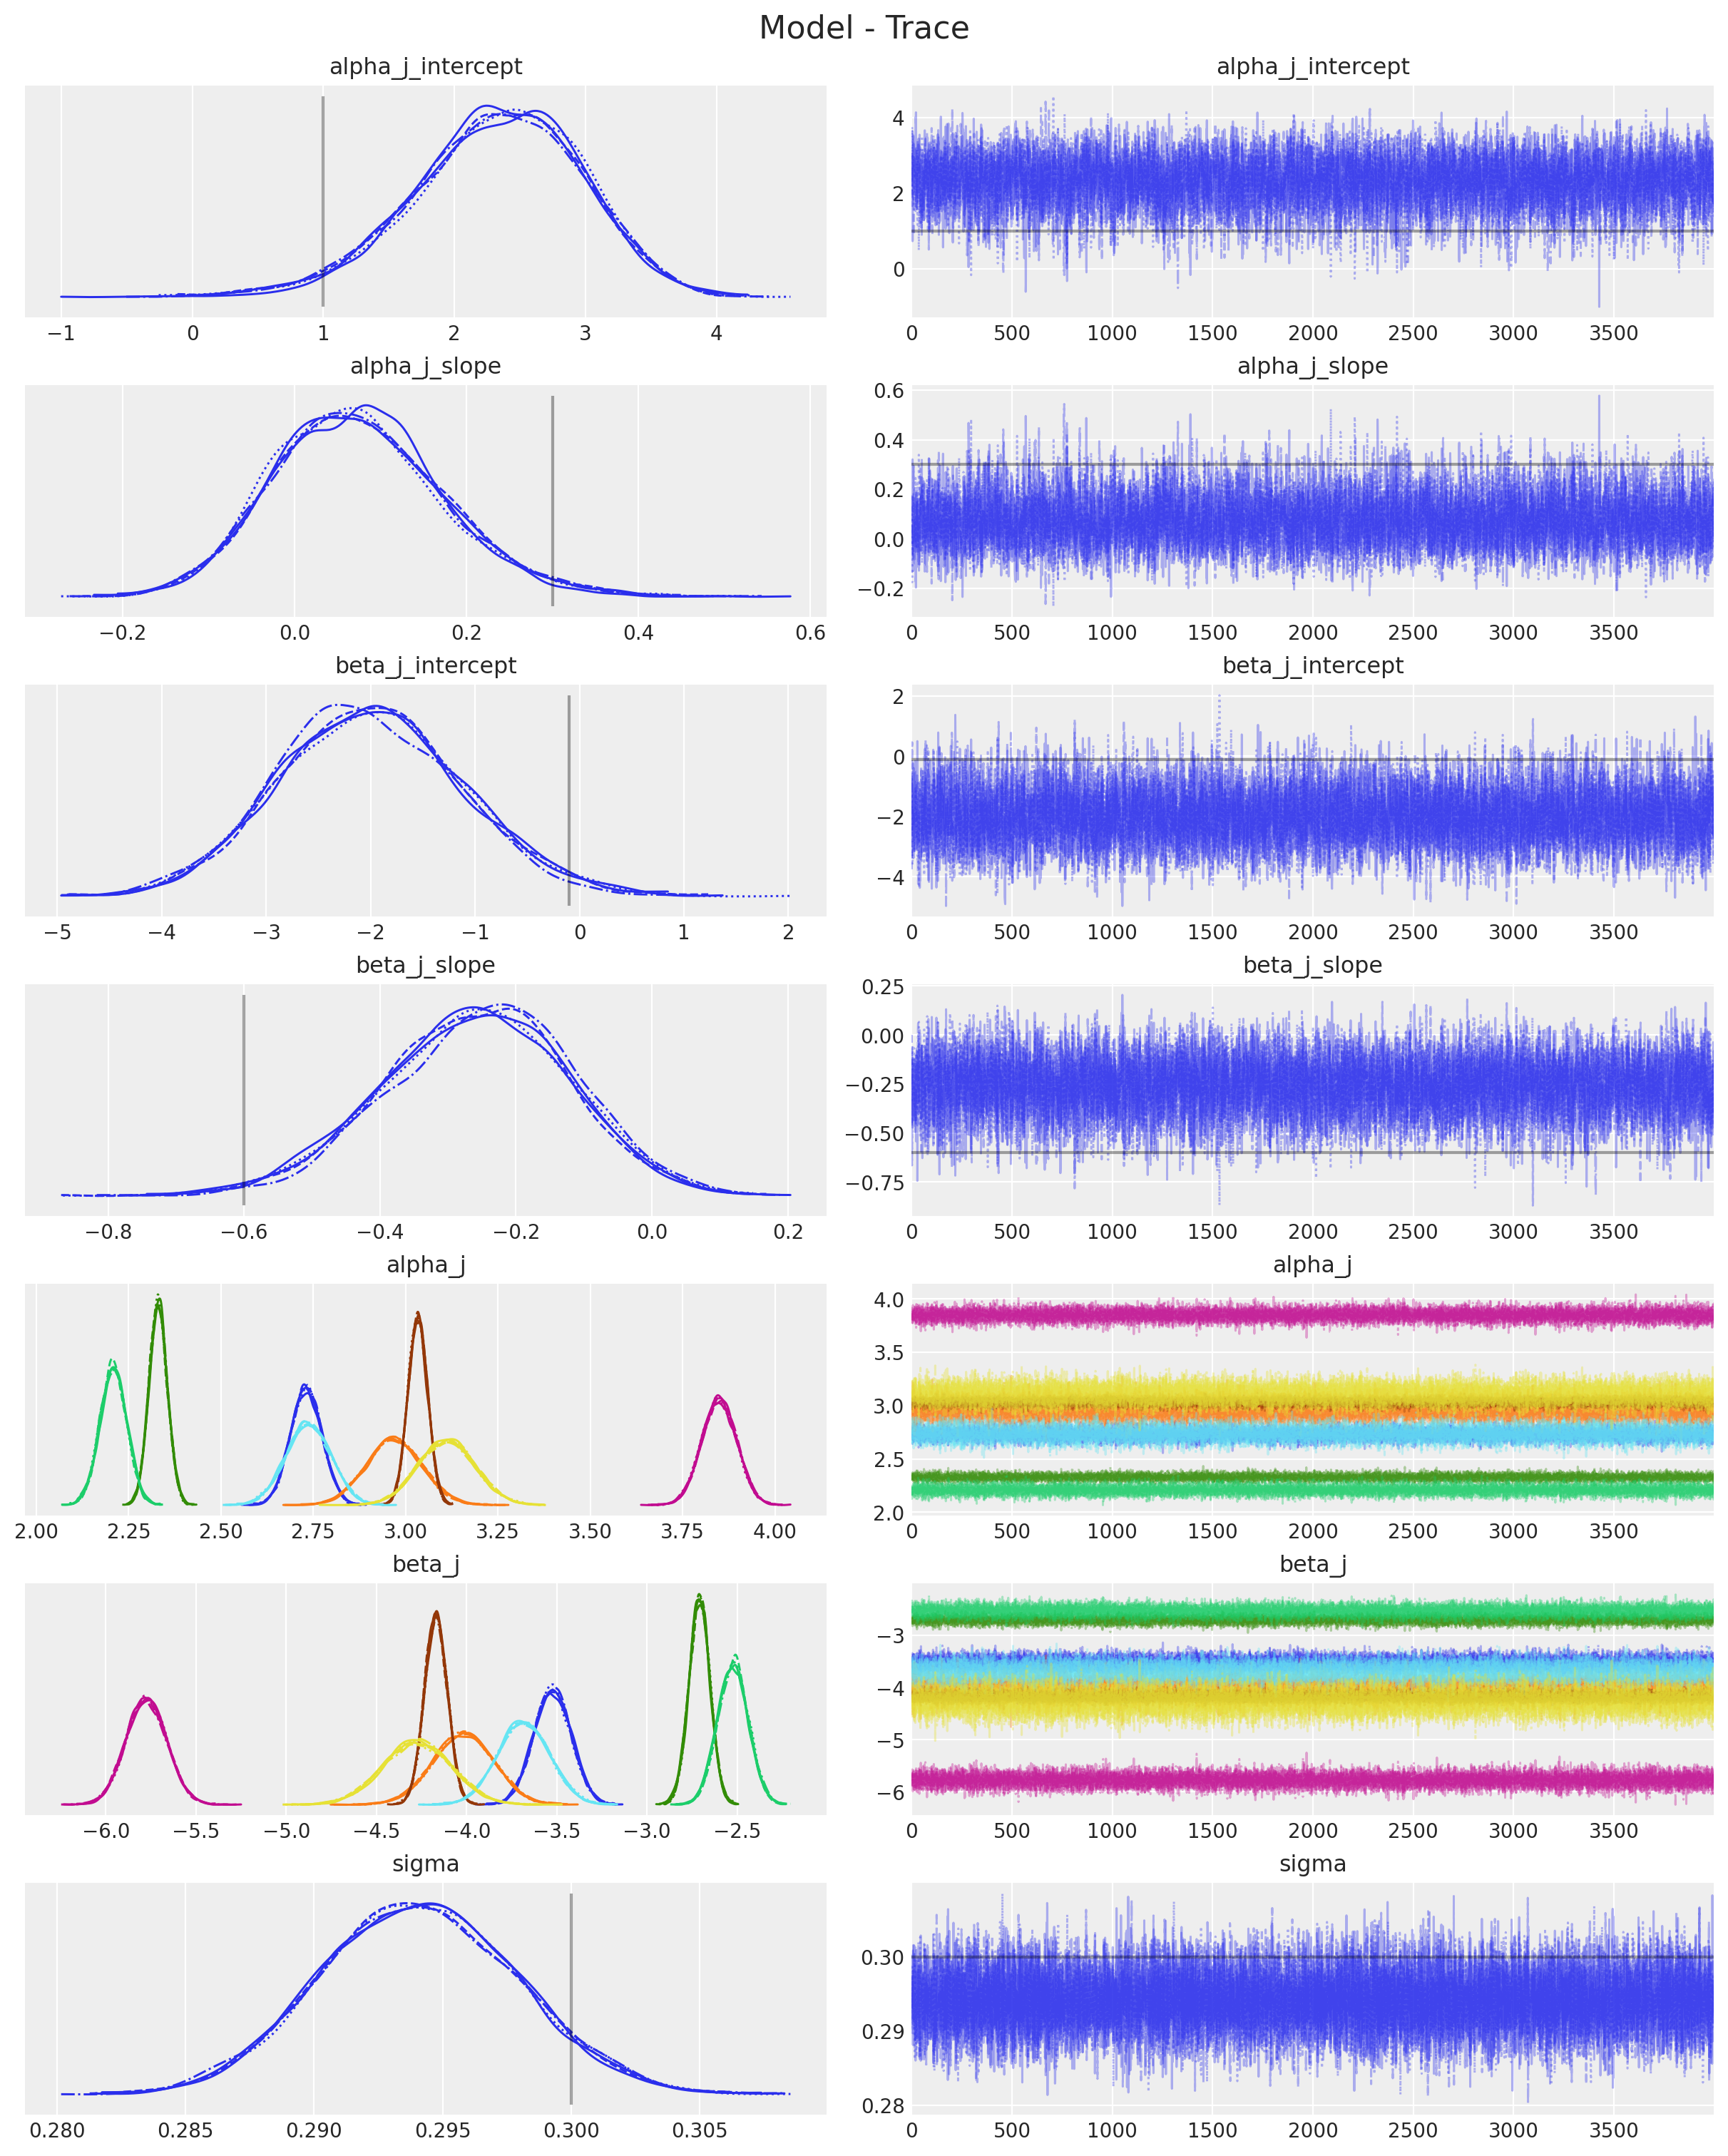

In [18]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    lines=[
        ("alpha_j_intercept", {}, data_generator.intercepts_lr_config.intercept),
        ("alpha_j_slope", {}, data_generator.intercepts_lr_config.slope),
        ("beta_j_intercept", {}, data_generator.slopes_lr_config.intercept),
        ("beta_j_slope", {}, data_generator.slopes_lr_config.slope),
        ("sigma", {}, data_generator.epsilon),
    ],
    compact=True,
    # kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace", fontsize=16)


array([[<Axes: ylabel='alpha_j_slope'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_j_intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha_j_intercept', ylabel='beta_j_slope'>,
        <Axes: xlabel='alpha_j_slope'>,
        <Axes: xlabel='beta_j_intercept'>]], dtype=object)

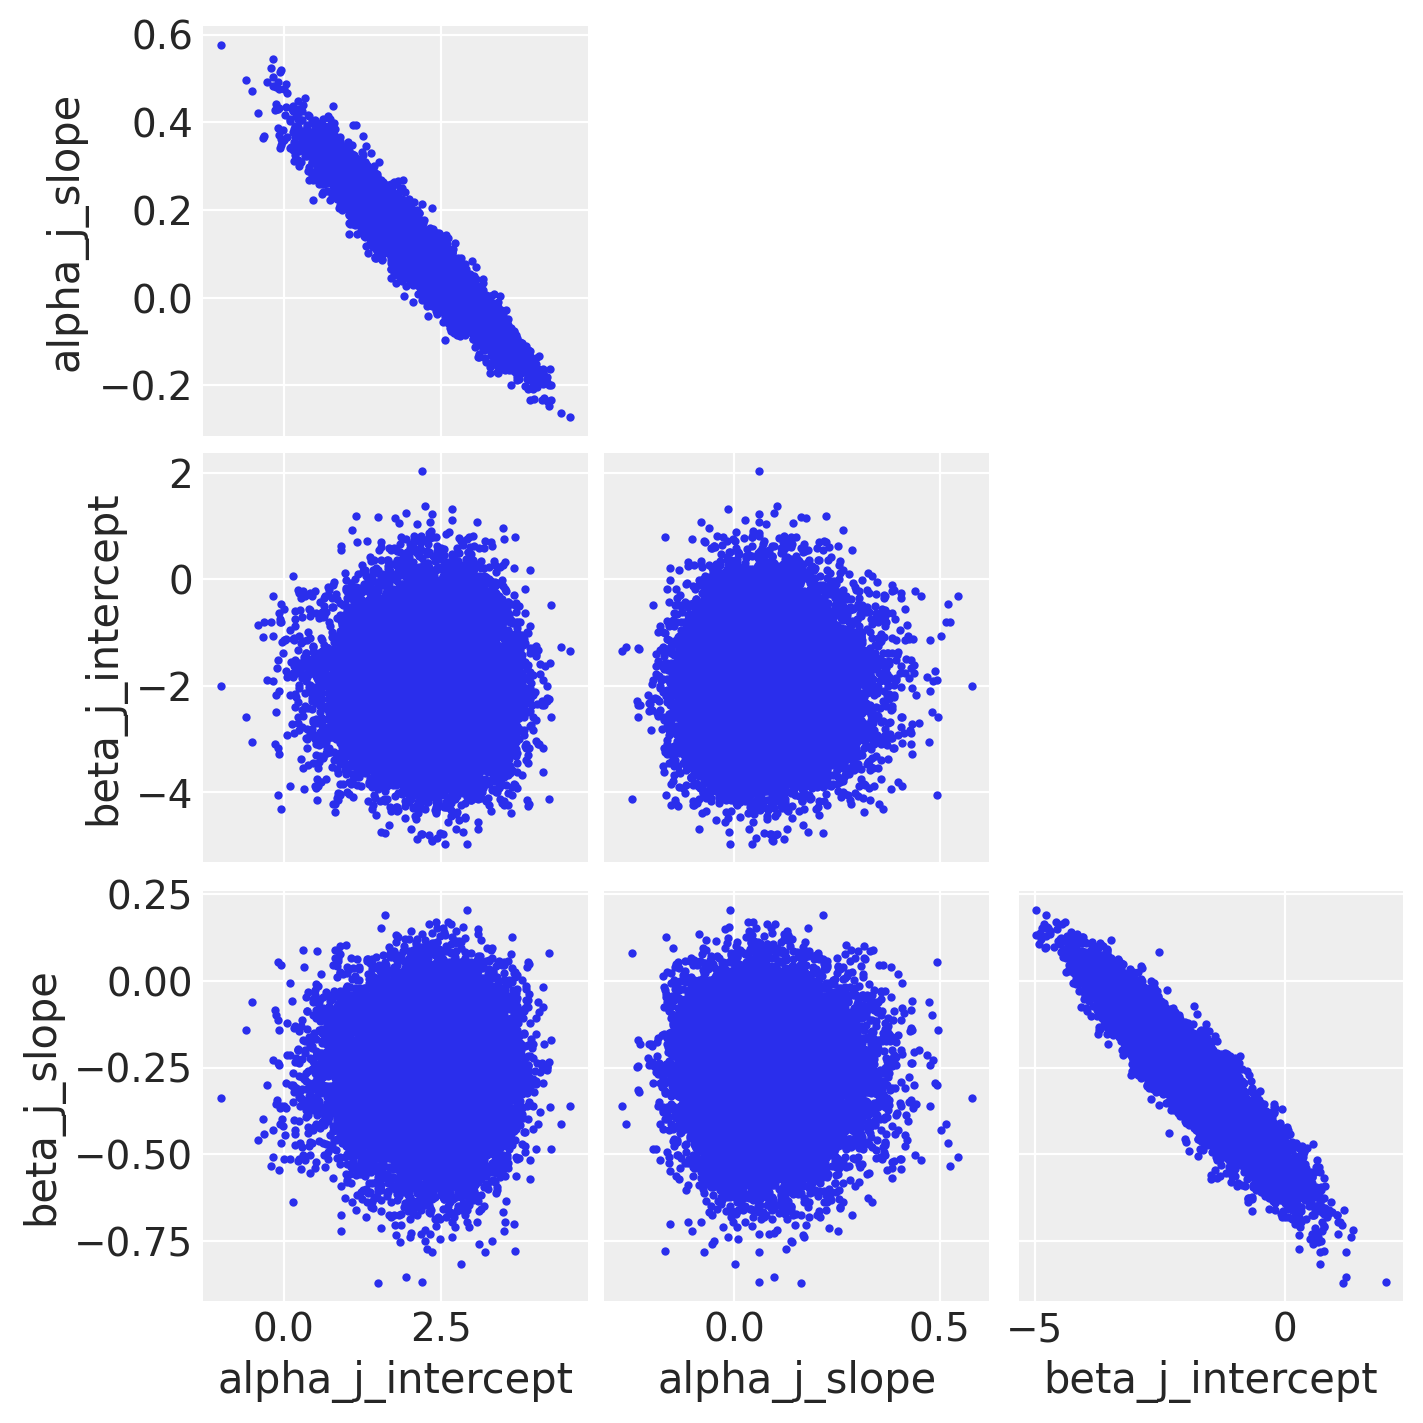

In [19]:
az.plot_pair(
    data=idata,
    var_names=[
        "alpha_j_intercept",
        "alpha_j_slope",
        "beta_j_intercept",
        "beta_j_slope",
    ],
    figsize=(7, 7),
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

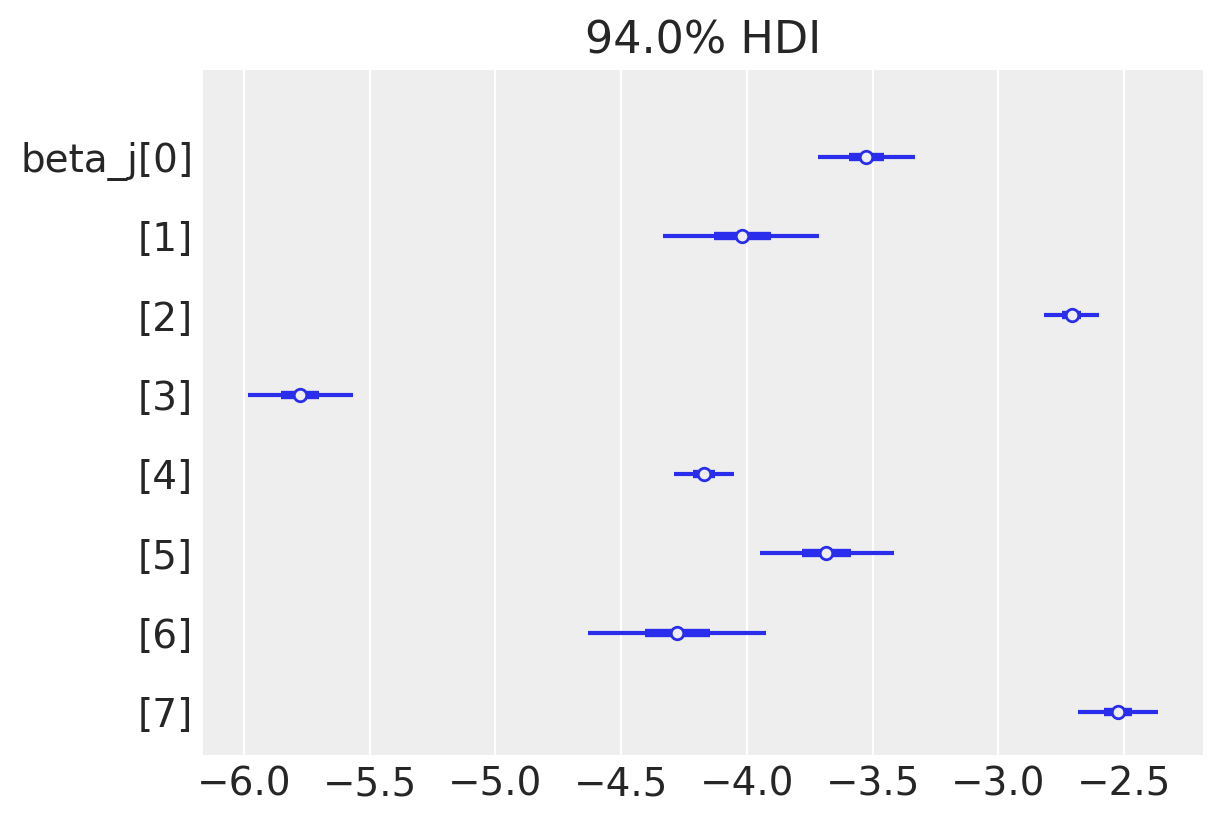

In [21]:
az.plot_forest(
    data=idata,
    var_names=["beta_j"],
    combined=True,
    figsize=(6, 4),
)

In [22]:
# ax = az.plot_ppc(
#     data=posterior_predictive,
#     observed_rug=True,
#     random_seed=seed,
# )
# ax.set(
#     title="Posterior Predictive Check",
#     xlabel="likelihood",
#     # xlim=(-0.5, 1.5),
# )


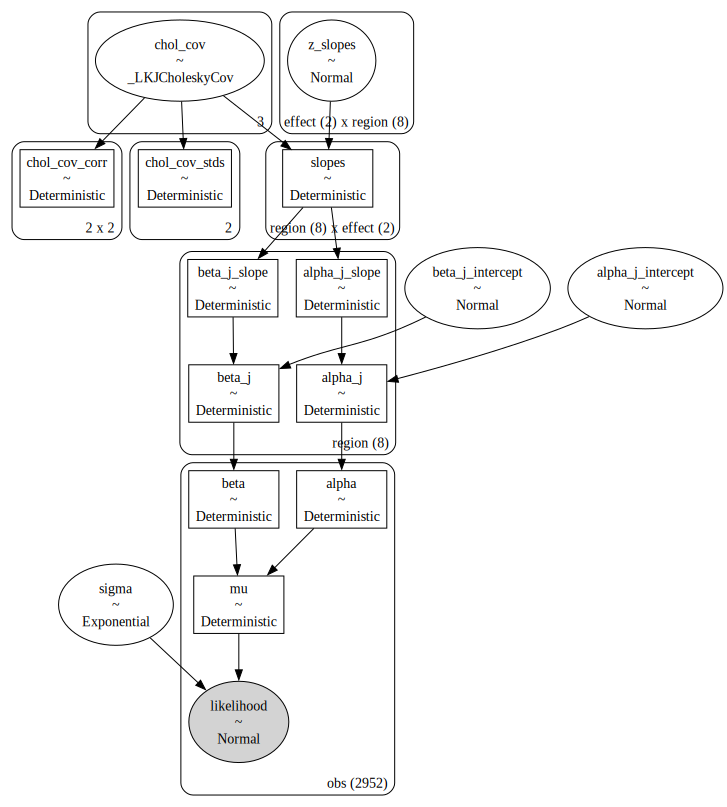

In [28]:
import pytensor.tensor as pt

# https://tomicapretto.github.io/posts/2022-06-12_lkj-prior/#model-3-correlated-priors-with-lkjcorr.

coords = {
    "store": store,
    "region": region,
    "obs": obs,
    "effect": ["intercept", "slope"],
}

with pm.Model(coords=coords) as model_cov:
    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)

    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)

    sd_dist = pm.HalfNormal.dist(sigma=0.01, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    z_slopes = pm.Normal(name="z_slopes", mu=0, sigma=1, dims=("effect", "region"))
    slopes = pm.Deterministic(
        name="slopes", var=pt.dot(chol, z_slopes).T, dims=("region", "effect")
    )

    alpha_j_slope = pm.Deterministic(
        name="alpha_j_slope", var=slopes[:, 0], dims="region"
    )

    beta_j_slope = pm.Deterministic(
        name="beta_j_slope", var=slopes[:, 1], dims="region"
    )

    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_intercept + alpha_j_slope * median_income.to_numpy(),
        dims="region",
    )

    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_intercept + beta_j_slope * median_income.to_numpy(),
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

    # --- Likelihood ---

    pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=log_quantities, dims="obs"
    )

pm.model_to_graphviz(model=model_cov)


In [29]:
with model_cov:
    pm.sample_prior_predictive(samples=10)

Sampling: [alpha_j_intercept, beta_j_intercept, chol_cov, likelihood, sigma, z_slopes]


In [30]:
with model_cov:
    idata_cov = pm.sample(
        target_accept=0.95,
        draws=4_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_cov = pm.sample_posterior_predictive(
        trace=idata_cov, random_seed=rng
    )


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.677857
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:32.578225
Transforming variables...


Sampling: [likelihood]


Transformation time =  0:00:01.360325


In [31]:
idata_cov["sample_stats"]["diverging"].sum().item()

0

In [32]:
var_names = [
    "alpha_j_intercept",
    # "alpha_j_slope",
    "beta_j_intercept",
    # "beta_j_slope",
    "slopes",
    "alpha_j",
    "beta_j",
    "sigma",
]

az.summary(data=idata_cov, var_names=var_names)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_j_intercept     2.853  0.064   2.733    2.971      0.001    0.001   
beta_j_intercept     -3.792  0.126  -4.032   -3.560      0.002    0.001   
slopes[0, intercept] -0.025  0.017  -0.056    0.008      0.000    0.000   
slopes[0, slope]      0.052  0.034  -0.012    0.117      0.000    0.000   
slopes[1, intercept]  0.022  0.018  -0.012    0.056      0.000    0.000   
slopes[1, slope]     -0.044  0.037  -0.115    0.024      0.000    0.000   
slopes[2, intercept] -0.089  0.012  -0.110   -0.067      0.000    0.000   
slopes[2, slope]      0.183  0.023   0.137    0.225      0.000    0.000   
slopes[3, intercept]  0.158  0.013   0.134    0.182      0.000    0.000   
slopes[3, slope]     -0.311  0.026  -0.362   -0.263      0.000    0.000   
slopes[4, intercept]  0.026  0.010   0.008    0.046      0.000    0.000   
slopes[4, slope]     -0.055  0.020  -0.094   -0.017      0.000    0.000   
slopes[5, intercept] -0.017  0.012  -0.039    0.006      0.000    0.000   
slopes[5, slope]      0.021  0.026  -0.027    0.069      0.000    0.000   
slopes[6, intercept]  0.032  0.012   0.009    0.056      0.000    0.000   
slopes[6, slope]     -0.061  0.027  -0.111   -0.011      0.000    0.000   
slopes[7, intercept] -0.066  0.007  -0.080   -0.052      0.000    0.000   
slopes[7, slope]      0.130  0.015   0.101    0.157      0.000    0.000   
alpha_j[0]            2.750  0.041   2.674    2.827      0.000    0.000   
alpha_j[1]            2.952  0.068   2.823    3.079      0.000    0.000   
alpha_j[2]            2.341  0.025   2.294    2.387      0.000    0.000   
alpha_j[3]            3.799  0.046   3.714    3.887      0.000    0.000   
alpha_j[4]            3.030  0.026   2.981    3.078      0.000    0.000   
alpha_j[5]            2.736  0.059   2.628    2.850      0.000    0.000   
alpha_j[6]            3.093  0.072   2.957    3.228      0.000    0.000   
alpha_j[7]            2.208  0.036   2.140    2.274      0.000    0.000   
beta_j[0]            -3.579  0.094  -3.757   -3.405      0.001    0.000   
beta_j[1]            -3.984  0.143  -4.250   -3.714      0.001    0.001   
beta_j[2]            -2.740  0.058  -2.851   -2.635      0.000    0.000   
beta_j[3]            -5.654  0.108  -5.863   -5.455      0.001    0.000   
beta_j[4]            -4.162  0.061  -4.278   -4.048      0.000    0.000   
beta_j[5]            -3.651  0.136  -3.908   -3.395      0.001    0.001   
beta_j[6]            -4.243  0.166  -4.557   -3.934      0.001    0.001   
beta_j[7]            -2.522  0.083  -2.681   -2.370      0.001    0.000   
sigma                 0.294  0.004   0.287    0.301      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
alpha_j_intercept       4417.0    6788.0    1.0  
beta_j_intercept        4592.0    7370.0    1.0  
slopes[0, intercept]    5837.0   10067.0    1.0  
slopes[0, slope]        6466.0   10820.0    1.0  
slopes[1, intercept]    8268.0   11939.0    1.0  
slopes[1, slope]        8959.0   13043.0    1.0  
slopes[2, intercept]    4819.0    8182.0    1.0  
slopes[2, slope]        5155.0    8850.0    1.0  
slopes[3, intercept]    6046.0   10015.0    1.0  
slopes[3, slope]        6926.0   11722.0    1.0  
slopes[4, intercept]    4762.0    8037.0    1.0  
slopes[4, slope]        5133.0    8598.0    1.0  
slopes[5, intercept]    7018.0   10994.0    1.0  
slopes[5, slope]        7945.0   11709.0    1.0  
slopes[6, intercept]    8287.0   12275.0    1.0  
slopes[6, slope]        9431.0   13566.0    1.0  
slopes[7, intercept]    5196.0    8767.0    1.0  
slopes[7, slope]        5742.0    9652.0    1.0  
alpha_j[0]             31093.0   15622.0    1.0  
alpha_j[1]             24751.0   14931.0    1.0  
alpha_j[2]             21895.0   15633.0    1.0  
alpha_j[3]             24614.0   15342.0    1.0  
alpha_j[4]             23453.0   16933.0    1.0  
alpha_j[5]             32059.0   16152.0    1.0  
alpha_j[6]             30502.0   15237.0    1.0  
alpha_j[7]            

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'alpha_j_slope', 'beta_j_slope'} expected from {'slopes', 'alpha_j_intercept', 'alpha_j', 'sigma', 'beta_j_intercept', 'beta_j'}
  warnings.warn(


Text(0.5, 0.98, 'Model - Trace')

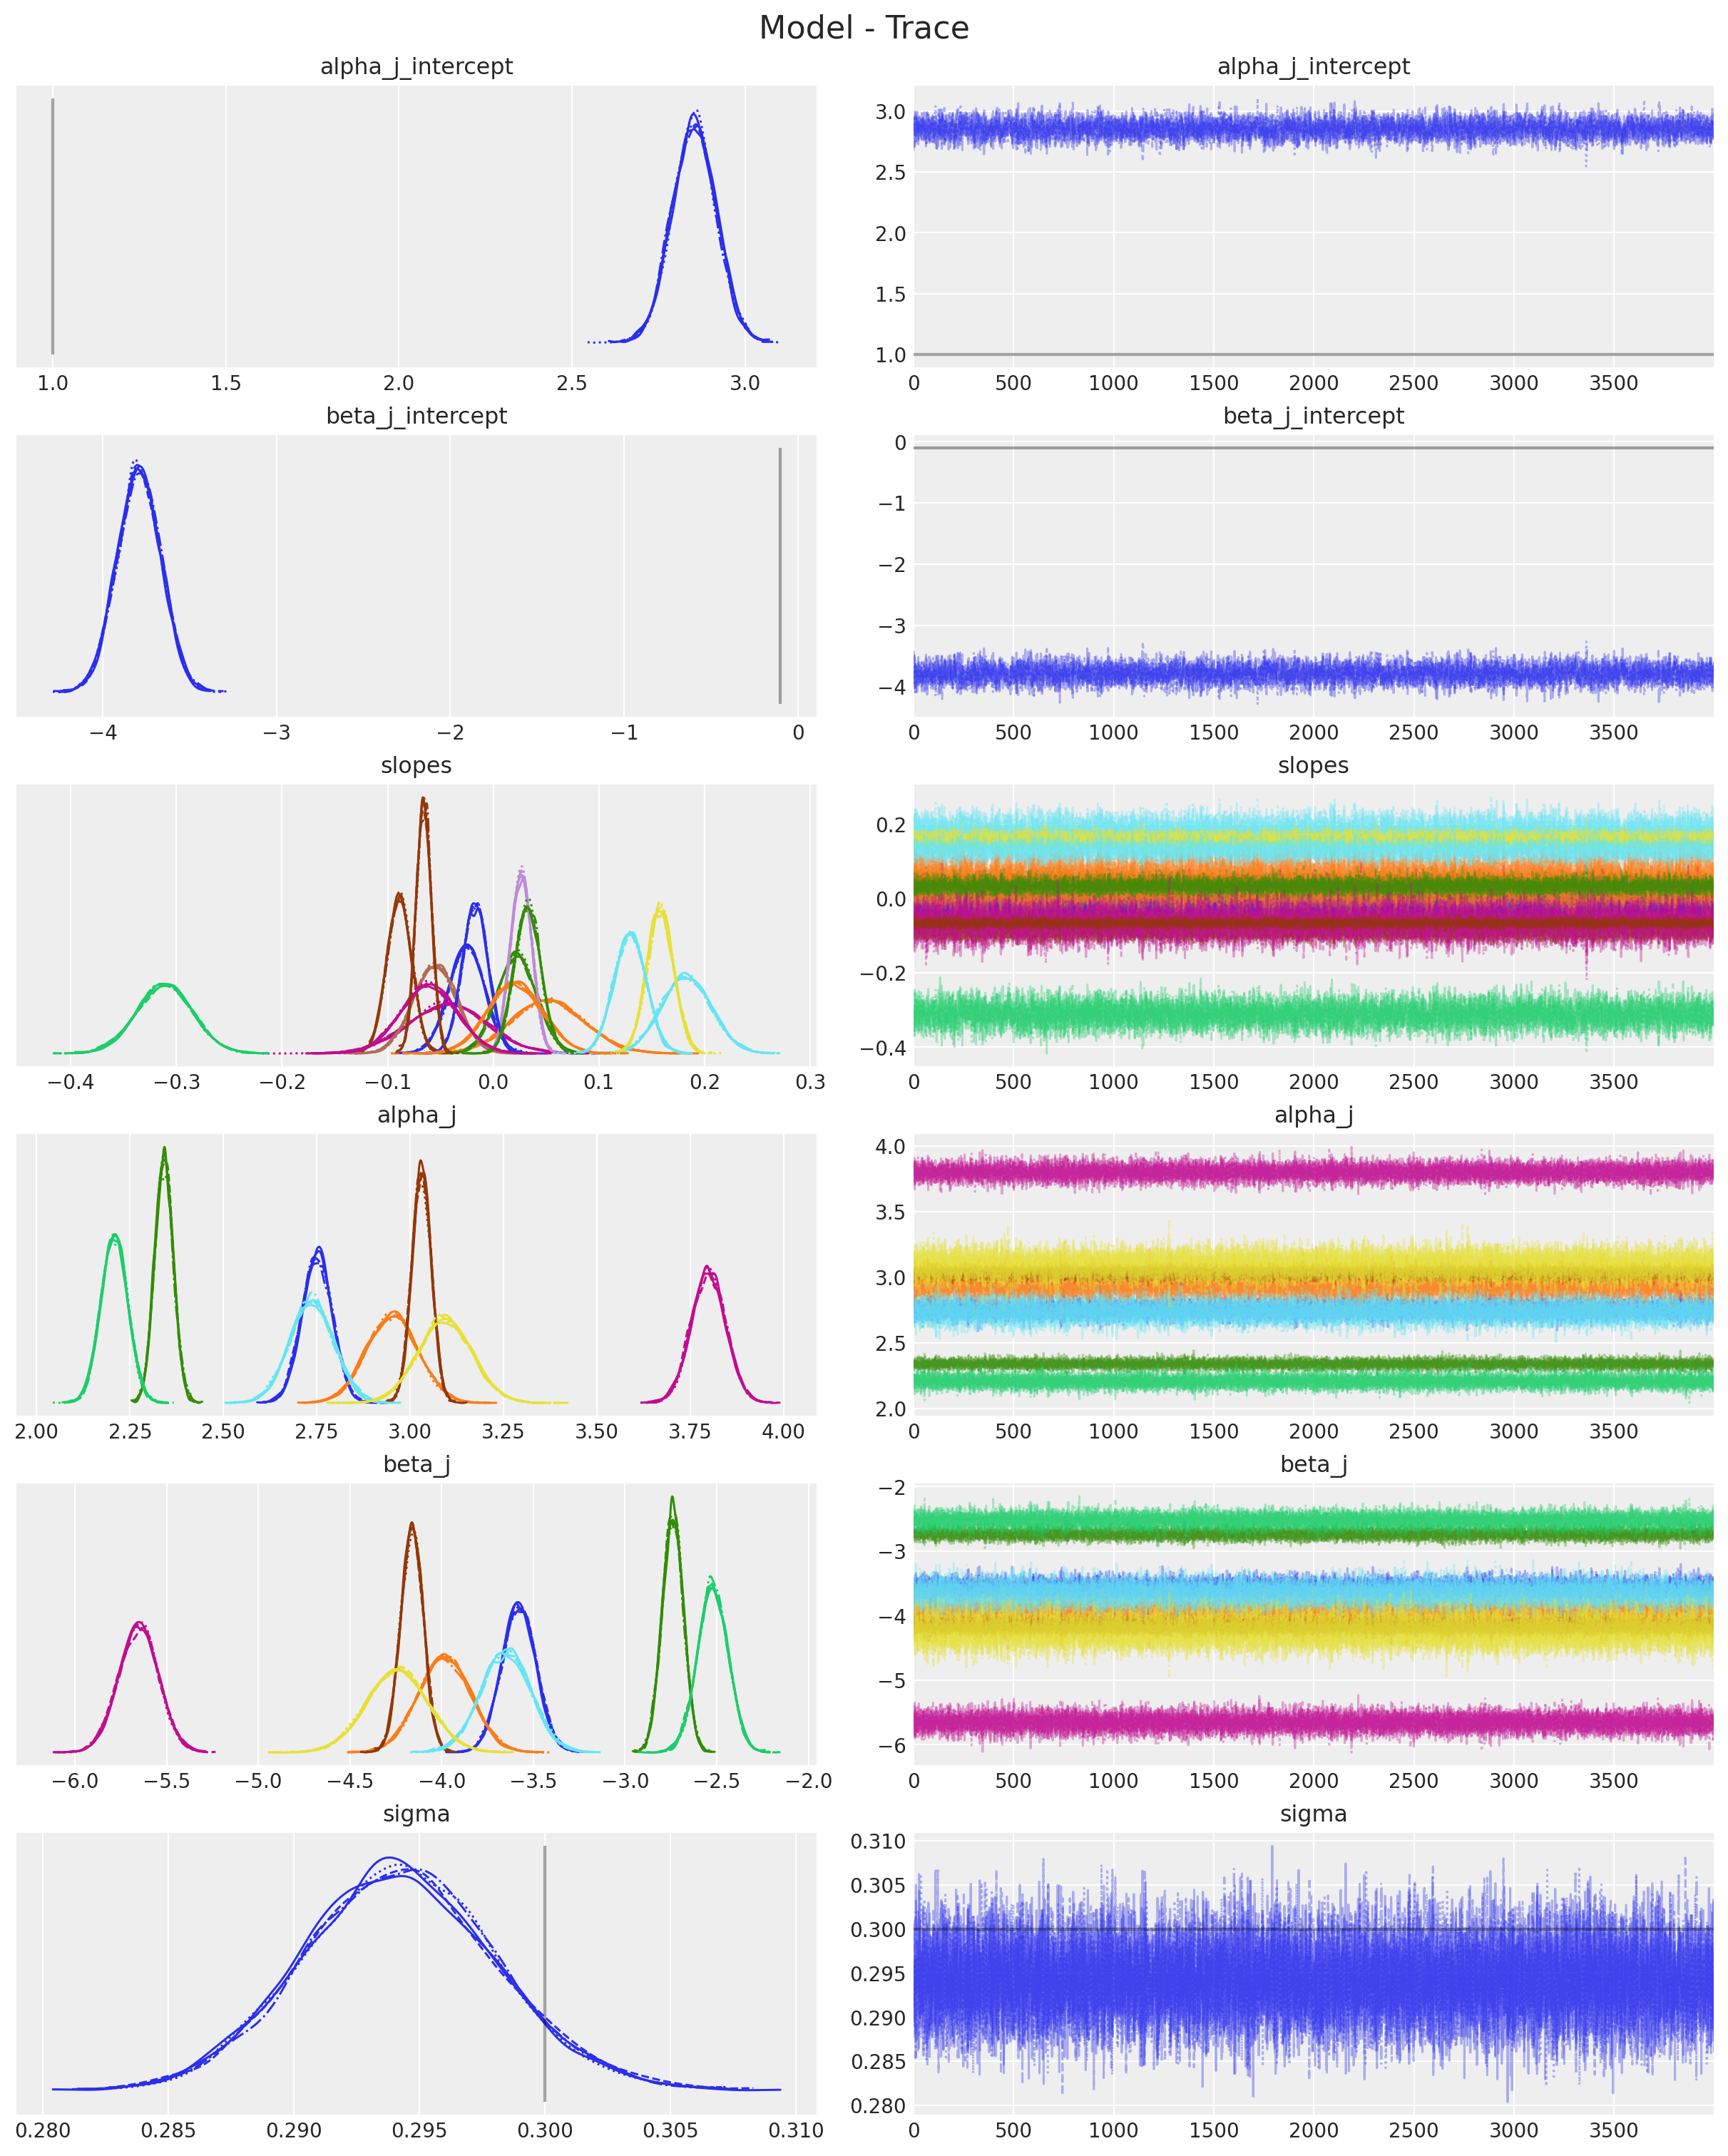

In [33]:
axes = az.plot_trace(
    data=idata_cov,
    var_names=var_names,
    lines=[
        ("alpha_j_intercept", {}, data_generator.intercepts_lr_config.intercept),
        ("alpha_j_slope", {}, data_generator.intercepts_lr_config.slope),
        ("beta_j_intercept", {}, data_generator.slopes_lr_config.intercept),
        ("beta_j_slope", {}, data_generator.slopes_lr_config.slope),
        ("sigma", {}, data_generator.epsilon),
    ],
    compact=True,
    # kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace", fontsize=16)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

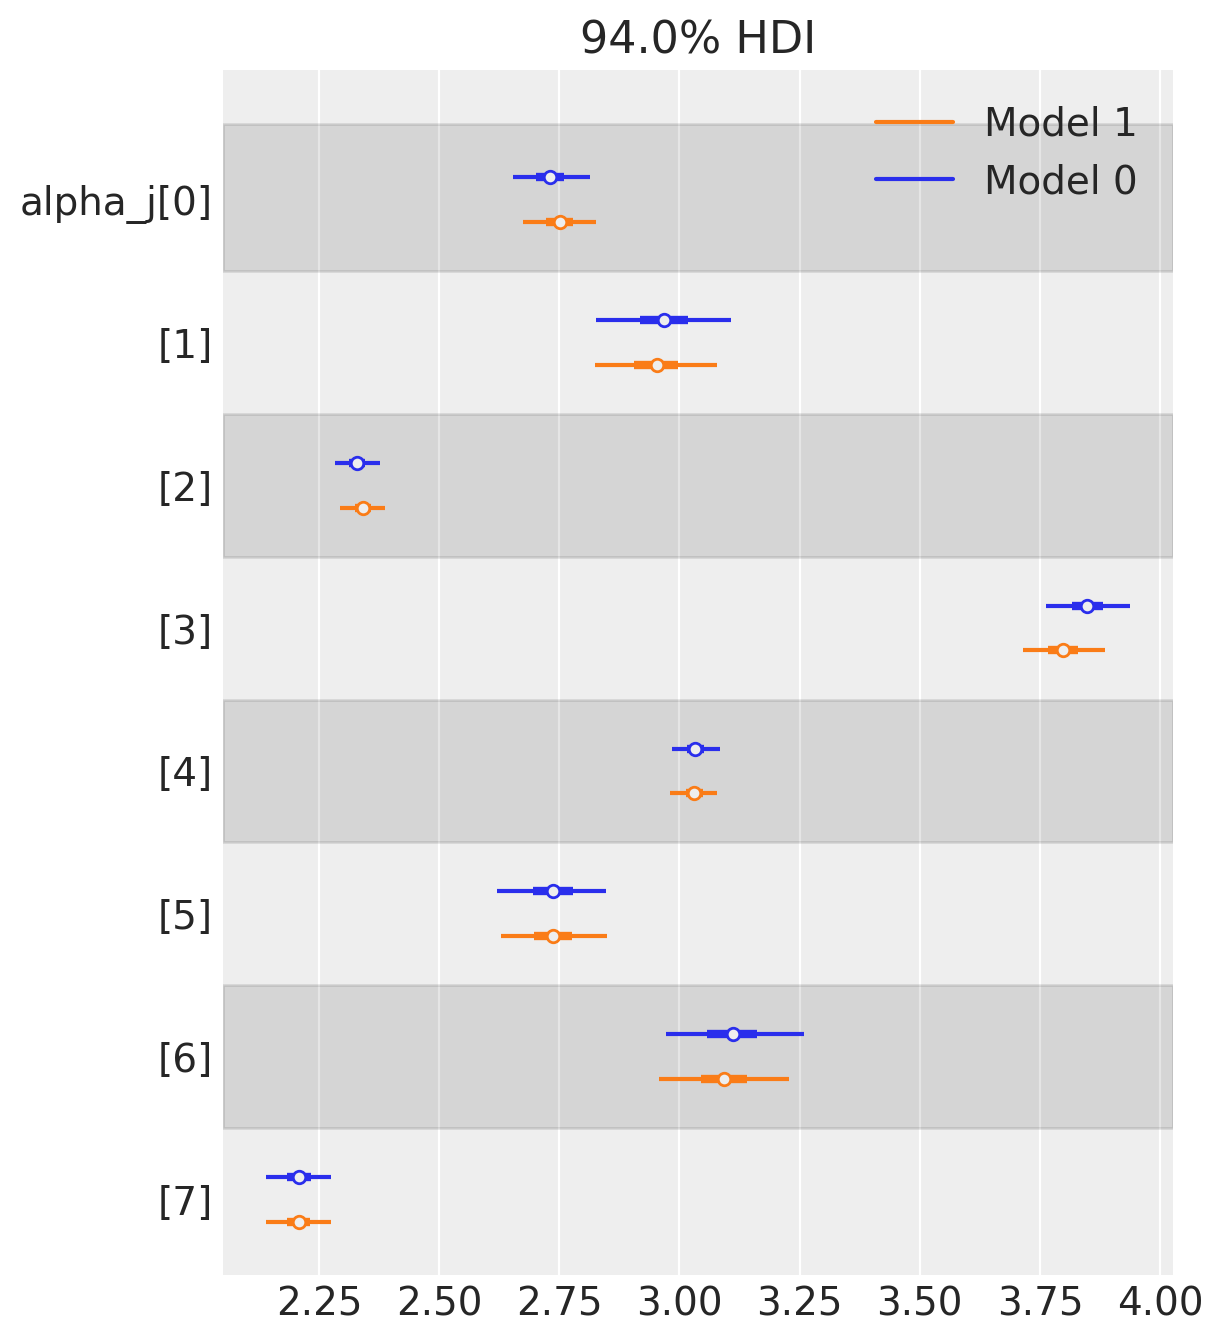

In [34]:
az.plot_forest(data=[idata, idata_cov], var_names=["alpha_j"], combined=True)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

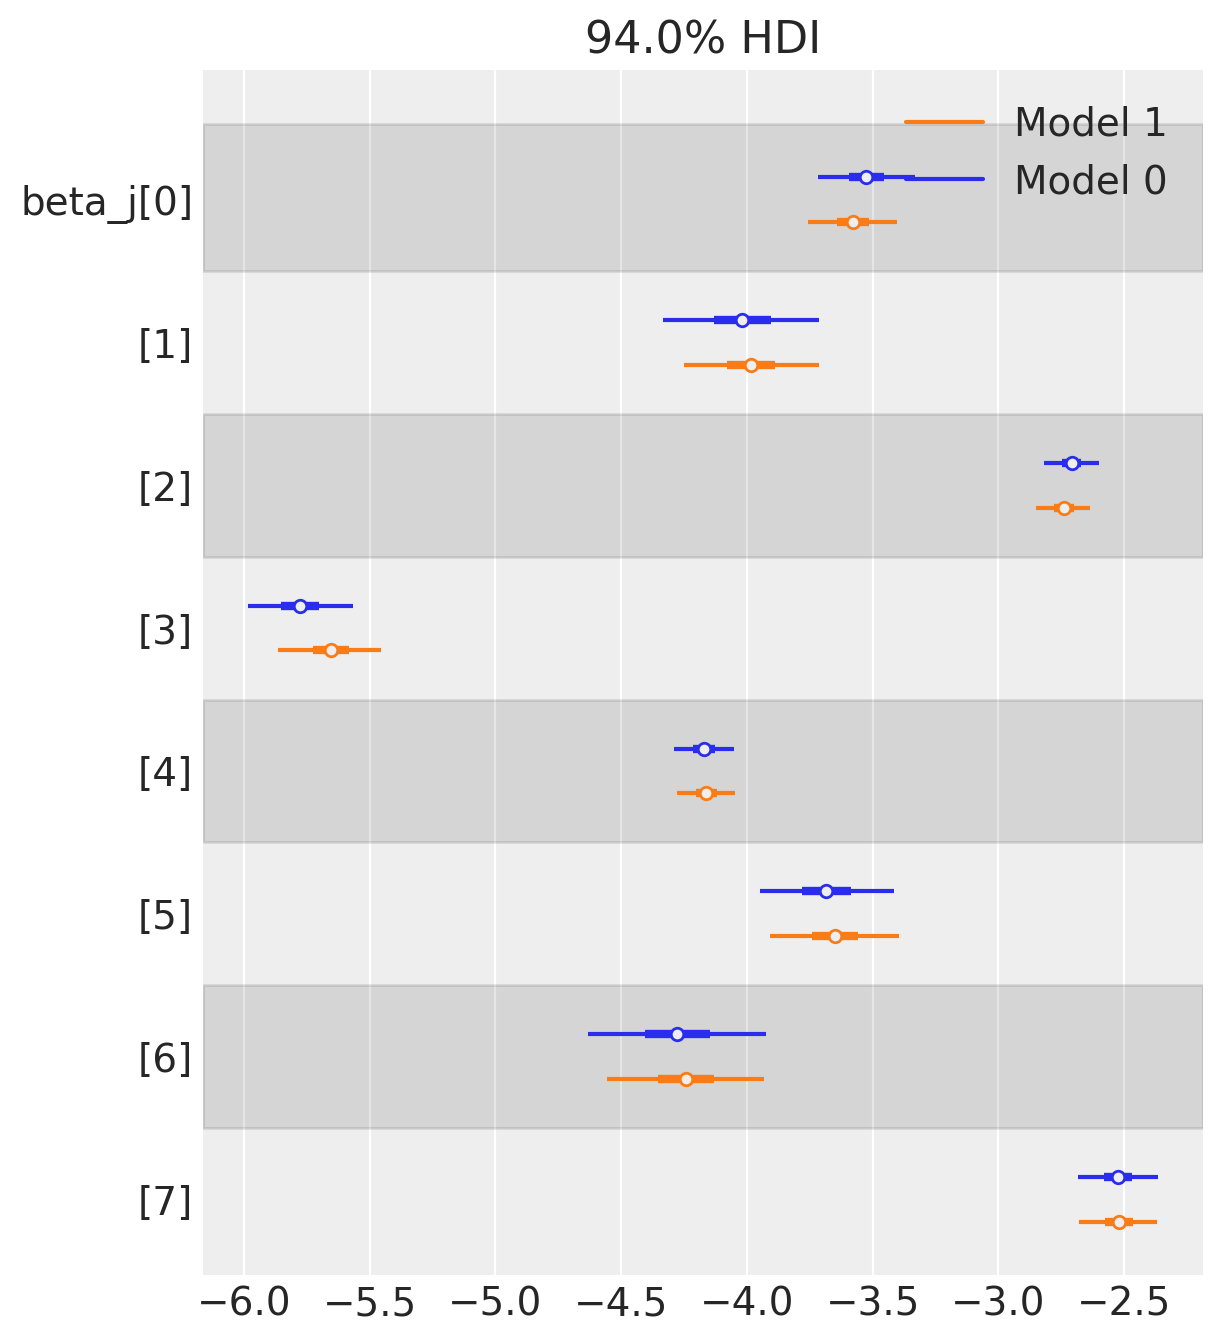

In [35]:
az.plot_forest(data=[idata, idata_cov], var_names=["beta_j"], combined=True)
